In [8]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from ctypes import windll
import geopandas as gpd
# Screen resolution
user32 = windll.user32
screensize = np.array((user32.GetSystemMetrics(0), user32.GetSystemMetrics(1)))
dpi=150
# Plot settings
plt.style.use('bmh')
plt.style.use('seaborn-talk')
plt.rcParams["figure.figsize"] = screensize/dpi
plt.rcParams["figure.dpi"] = dpi
# Root
machine = 'local' # 'local' or 'remote'
if machine == 'local':
    root = r'D:\ESRP\RechargeData_Alex'
elif machine == 'remote':
    root = r'P:\AMoody\ESRP\RechargeData_Alex'

sys.path.append(os.path.join(root,'FPT','Wetlands'))
sys.path.append(os.path.join(root,'FPT'))

# Conversions
kcf2af = 1000/43560 # 1000 ft3 in kft3, 43560 ft2 per acre, 1000 AF in 1KAF

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Updates to ESPAM2.2 Water Budget
January 2015 - September 2017

### Outline
1. Compare growing season METRIC ET with ETIdaho estimates in overlapping years
    + 1986, 1992, 1996, 2000, 2002, 2006, 2008, 2009, 2010, 2011, 2013
2. Examine updated water budget components
    + DIV, PCH, FPT, NIR, TRB, OFF
    + Waiting for updated irrigated lands to process METRIC
        + No CIR, ETI

In [3]:
# Stress periods dictionary
stress_periods = ['S{0:03d}'.format(x) for x in  np.arange(1,450)]
stress_ts = pd.date_range(end='2017-9-1',periods=len(stress_periods),freq='MS').values
sp2ts=dict(zip(stress_periods,stress_ts))
ts2sp=dict(zip(stress_ts,stress_periods))

In [4]:
# Compare 1979-2014 FPT file that uses ETIdaho with METRIC 
# Define timestamps and stress periods
stress_periods = ['S{0:03d}'.format(x) for x in  np.arange(1,450)]
stress_ts = pd.date_range(end='2017-9-1',periods=len(stress_periods),freq='MS').values
sp2ts=dict(zip(stress_periods,stress_ts))
ts2sp=dict(zip(stress_ts,stress_periods))

# Just METRIC months
# fMETRIC = r'FPT_ETIDAHO_METRIC_201501_201709_noresamp.csv'
fMETRIC = os.path.join(root,'FPT','Wetlands','WetlandsFPT_METRIC_1986_2017.csv')

dfMETRICbase = pd.read_csv(fMETRIC, header=0, index_col='FPT_NAME') 
# Get acres per FPT ID
dfMETRICarea = dfMETRICbase.filter(regex='Area|ACRES')
dfMETRIC = dfMETRICbase.filter(regex='FPT_.*')
dfMETRIC = dfMETRIC.groupby('FPT_NAME').sum()
datestr = dfMETRIC.columns.tolist()
datedt = [ pd.datetime.strptime(s[-6:],'%Y%m') for s in datestr]
dfMETRIC=dfMETRIC.rename(columns =  dict(zip(dfMETRIC.columns,datedt)))
dfMETRIC.sort_index(level=0,axis=1,inplace=True)
dfMETRIC.sort_index(axis=0,inplace=True)

#FPT through SP416. Extract ETIdaho FPT for wetlands
fETI = r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\ESPAM2_FPT_201412.csv'
dfETI = pd.read_csv(fETI, header=0, index_col=0)
FPTold = dfETI.loc[dfETI.index.str.contains('N|W'),:]
FPTold.rename(columns=sp2ts,inplace=True)

# Get column shared by both FPTs and Merge, Transpose
dfMETRIC = dfMETRIC.loc[FPTold.index,:]
FPTnew = FPTold.copy()
cols = dfMETRIC.columns.intersection(FPTold.columns)
# Drop FPTnew cols contained in METRIC calcs
FPTnew.loc[:,cols] = dfMETRIC.loc[:,cols].values

# Ft3 to AF
FPTnew = FPTnew.T.div(1000).mul(kcf2af)
FPTold = FPTold.T.div(1000).mul(kcf2af)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [5]:
'''The column Area_ac describes the area for the entire wetland. Acres describes the area for the specific polygon 
in the wetland. A given wetland (unique FPT_NAME) can have multiple polygons, so when grouping, be mindful of this fact.
If using Area_ac, take the mean. If using ACRES, use the sum'''
pd.concat([dfMETRICarea.groupby('FPT_NAME').sum(),dfMETRICarea.groupby('FPT_NAME').mean()],axis=1)
WetlandAreaNew = dfMETRICarea['ACRES'].groupby('FPT_NAME').sum()
WetlandAreaOld = dfMETRICarea['Area_ac'].groupby('FPT_NAME').mean()

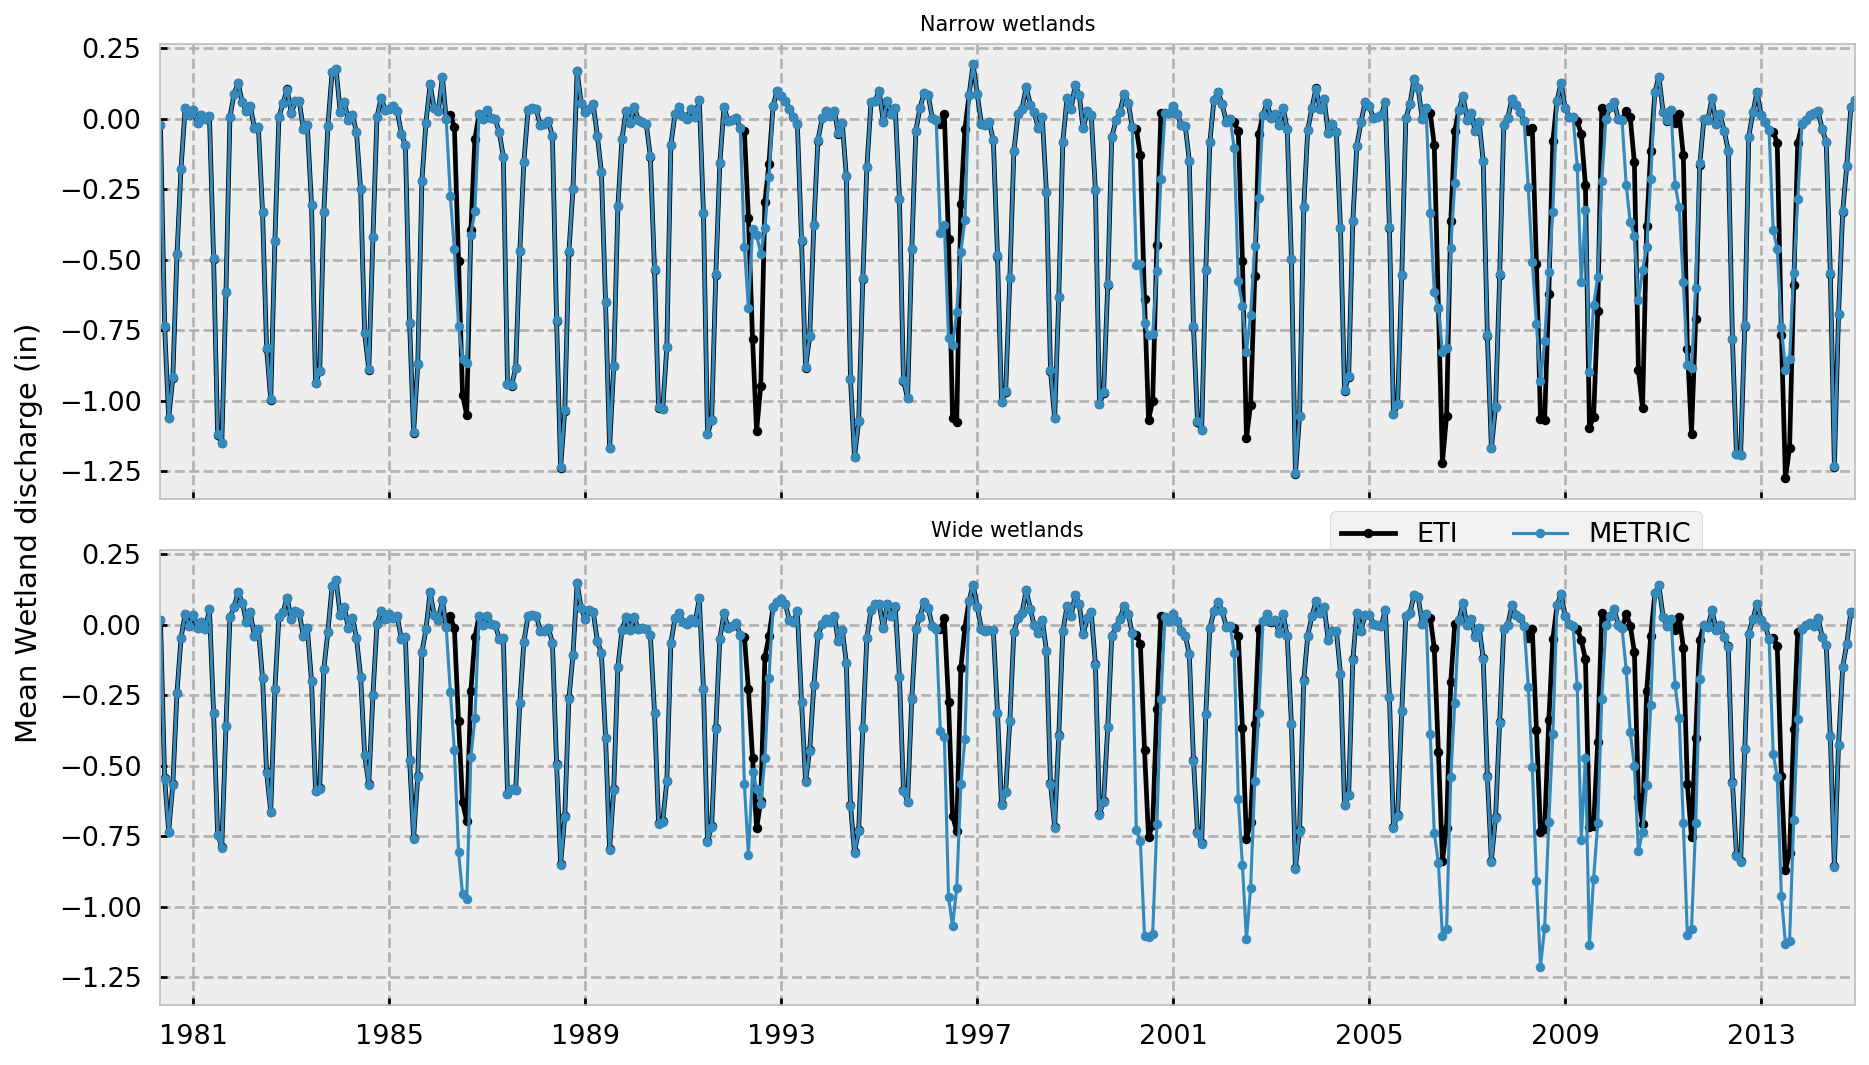

In [9]:
#------------------------------------------------------------------------------
# Plot 1: old narrow wetlands vs new narrow wetlands. Shade in METRIC years
wetlandflag = FPTnew.columns.str.contains('W')
#FPTnew.groupby(FPTnew.columns.str[0],axis=1).mean().plot()

fig, ax = plt.subplots(2,1,sharex=True,sharey=True);
fillidx = FPTnew.index.isin(cols)
#ax[0].fill_between(FPTnew.index,-7e3,1.5e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5);
ax[0].plot(FPTold.filter(regex='N.*').div(WetlandAreaOld).mean(axis=1),'.k-',label=r'ETI');
ax[0].plot(FPTnew.filter(regex='N.*').div(WetlandAreaNew).mean(axis=1),label=r'METRIC',linewidth=1.5,marker='.');
#ax[0].set_ylim((-3e3,5e2));

#ax[1].fill_between(FPTnew.index,-7e4,1.5e4,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5);
ax[1].plot(FPTold.filter(regex='W.*').div(WetlandAreaOld).mean(axis=1),'.k-',label=r'ETI');
ax[1].plot(FPTnew.filter(regex='W.*').div(WetlandAreaNew).mean(axis=1),label=r'METRIC',linewidth=1.5,marker='.');
#ax[1].set_ylim((-7e3,2e3));t

ax[0].set_xlim(('1980-5-1','2014-12-1'));
ax[0].set_title('Narrow wetlands',fontsize=10);
ax[1].set_title('Wide wetlands',fontsize=10);
fig.text(0.03,0.5,r'Mean Wetland discharge (in)',
         va='center', rotation='vertical',
         fontsize=14)
fig.tight_layout(rect=(.05,0,1,1));
ax[0].legend(bbox_to_anchor=[0.8, -.08], loc='center',ncol=2);

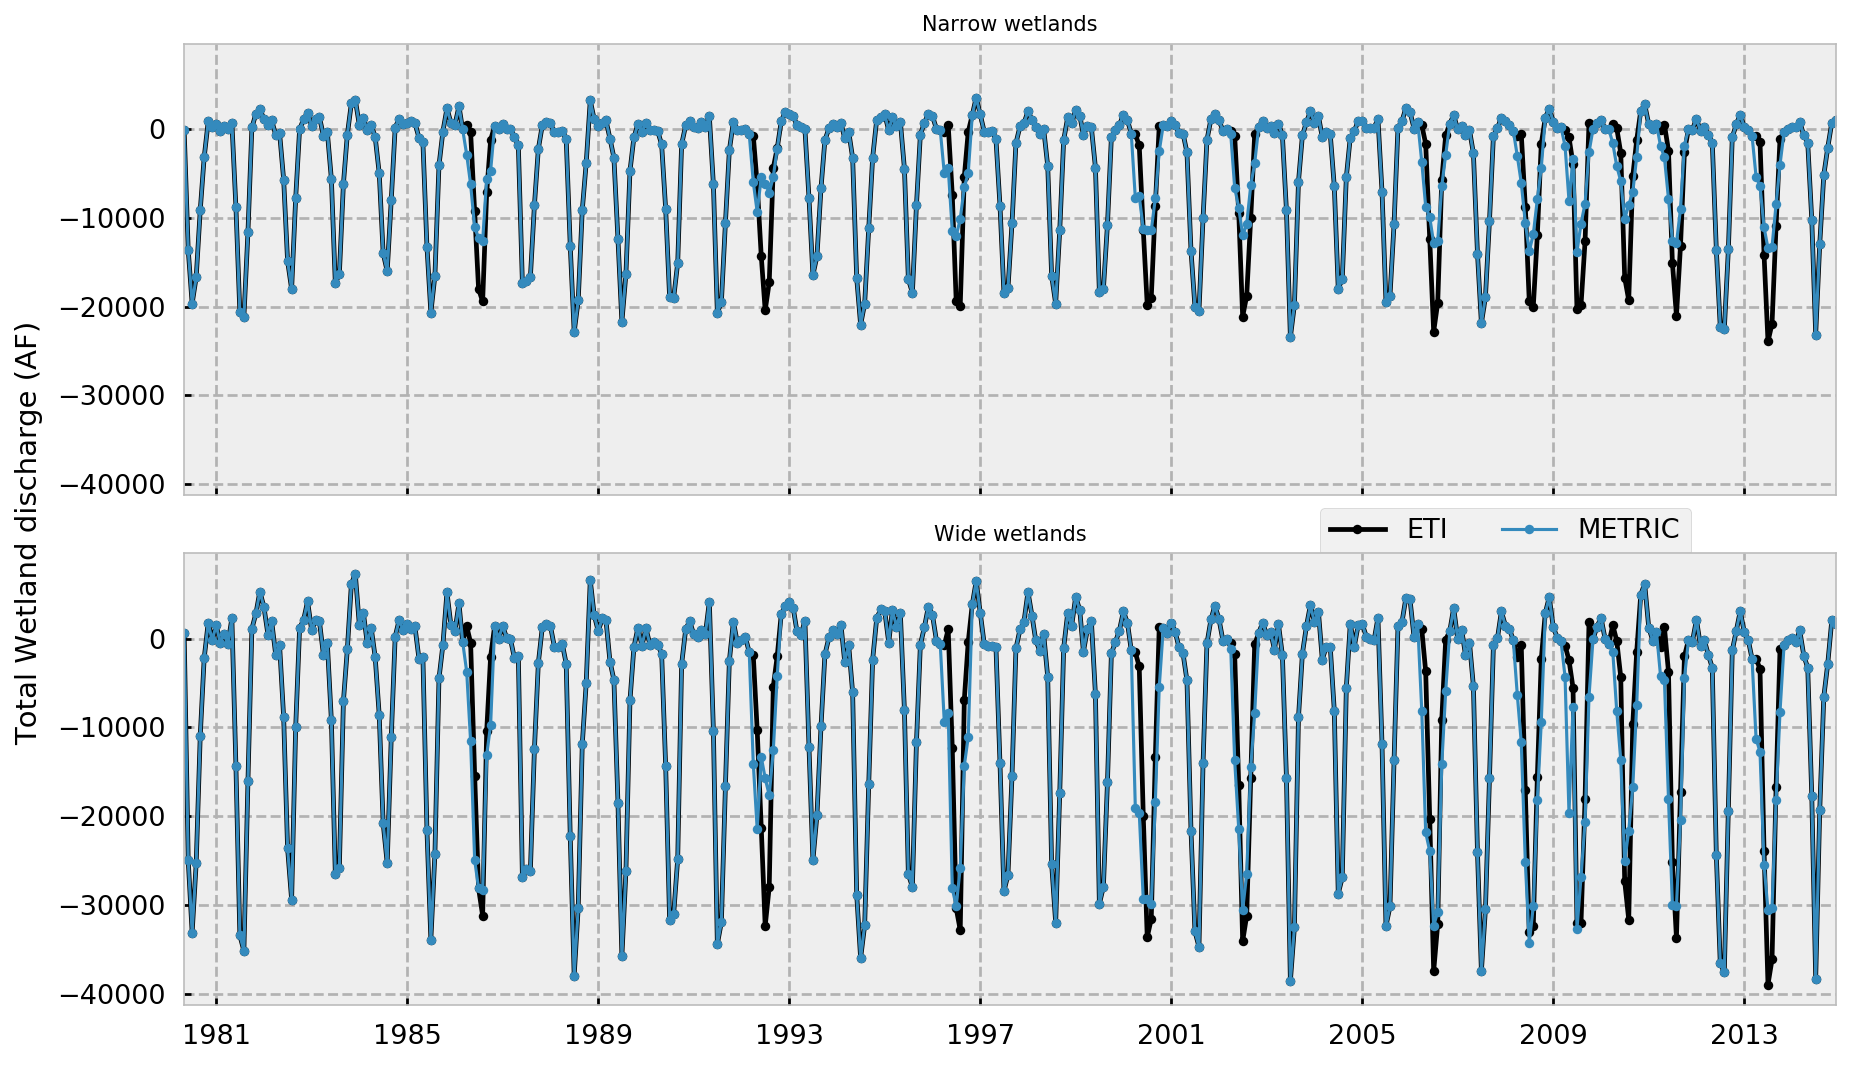

In [10]:
# ----------------------------------------------------------------------------
# Plot 1b. Same as above, but sum of all narrow or wide wetlands

fig1b, ax1b = plt.subplots(2,1,sharex=True,sharey=True)
fillidx = FPTnew.index.isin(cols)
#ax[0].fill_between(FPTnew.index,-7e3,1.5e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax1b[0].plot(FPTold.filter(regex='N.*').sum(axis=1),'.k-',label=r'ETI')
ax1b[0].plot(FPTnew.filter(regex='N.*').sum(axis=1),label=r'METRIC',linewidth=1.5,marker='.')
#ax1b[0].set_ylim((-3e3,5e2))

#ax[1].fill_between(FPTnew.index,-7e4,1.5e4,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax1b[1].plot(FPTold.filter(regex='W.*').sum(axis=1),'.k-',label=r'ETI',)
ax1b[1].plot(FPTnew.filter(regex='W.*').sum(axis=1),label=r'METRIC',linewidth=1.5,marker='.')
#ax1b[1].set_ylim((-7e3,2e3))

ax1b[0].set_xlim(('1980-5-1','2014-12-1'))
ax1b[0].set_title('Narrow wetlands',fontsize=10)
ax1b[1].set_title('Wide wetlands',fontsize=10)
fig1b.text(0.04,0.5,r'Total Wetland discharge (AF)',
         va='center', rotation='vertical',
         fontsize=14)
fig1b.tight_layout(rect=(.05,0,1,1))
ax1b[0].legend(bbox_to_anchor=[0.8, -.08], loc='center',ncol=2);

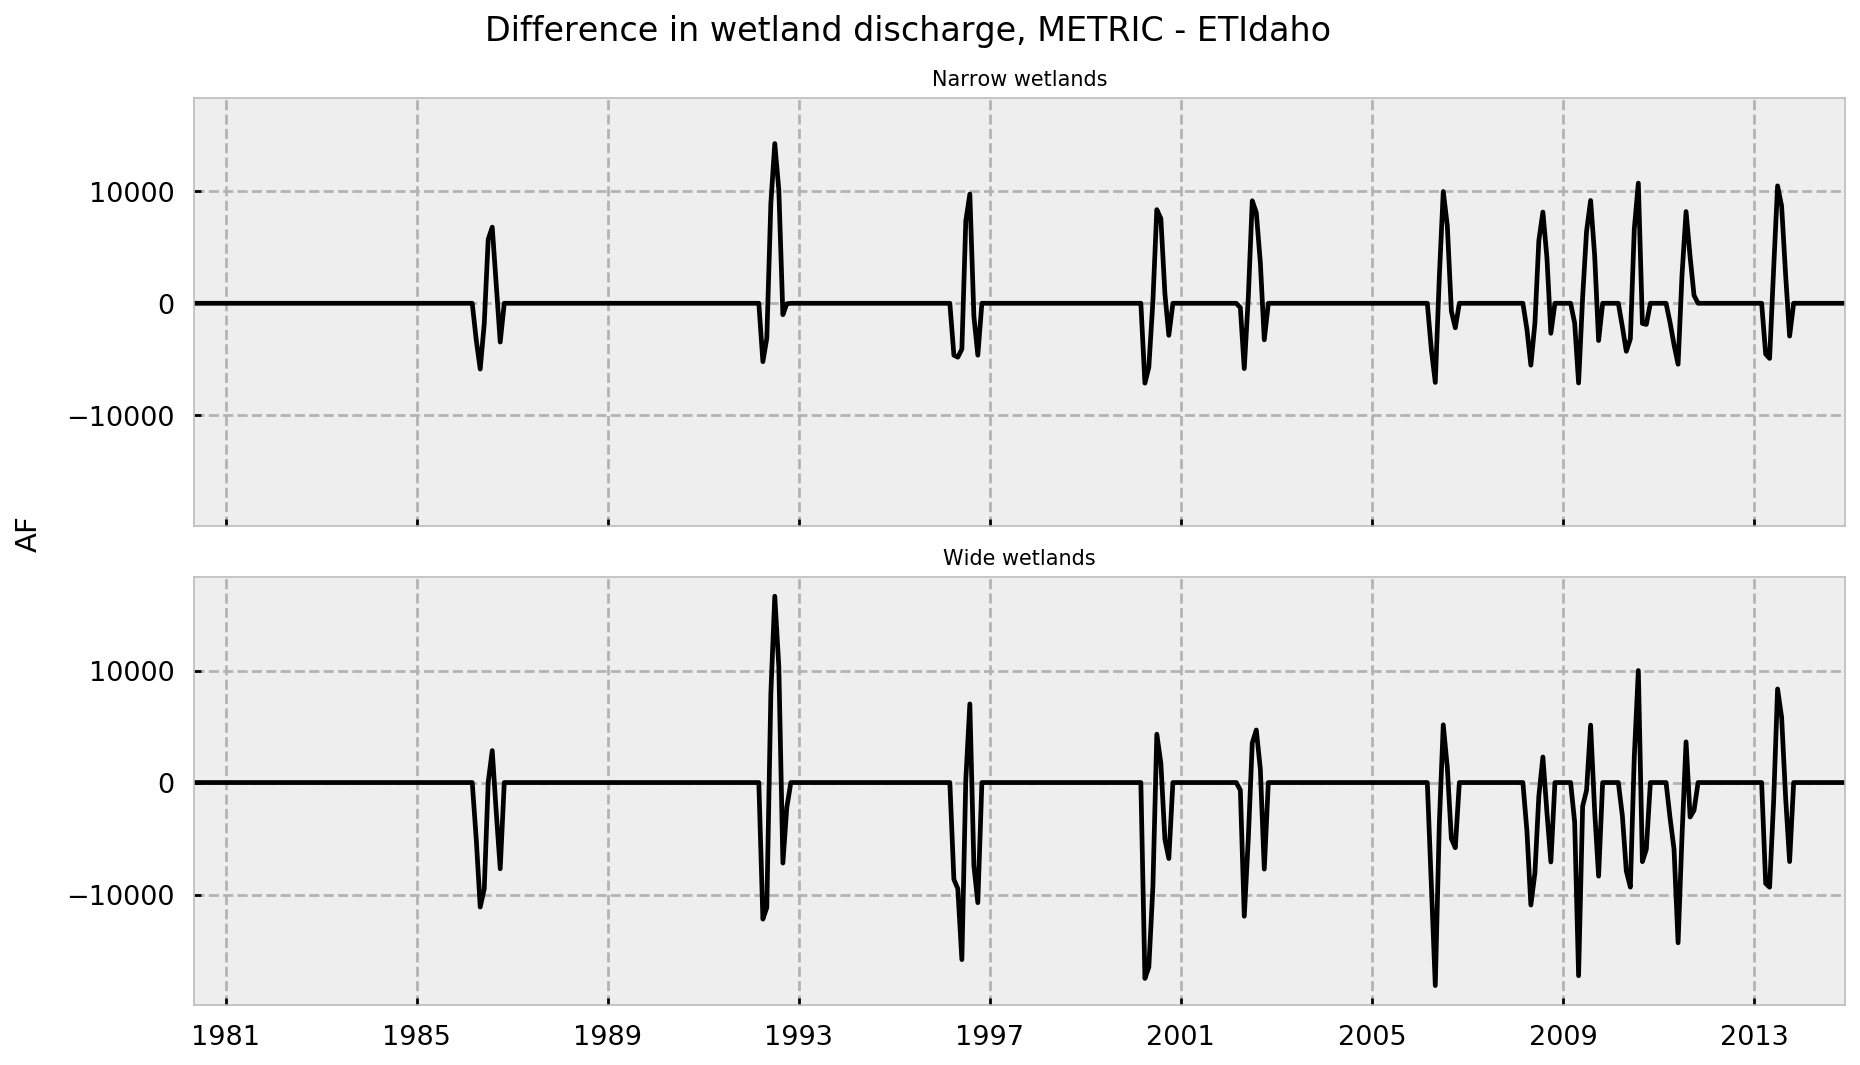

In [13]:
#------------------------------------------------------------------------------
# Fig 2. Differences
fig2, ax2 = plt.subplots(2,1,sharex=True,sharey=True)

fillidx = FPTnew.index.isin(cols)
#ax2[0].fill_between(FPTnew.index,-2e3,1e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax2[0].plot(FPTnew.filter(regex='N.*').sum(axis=1)-FPTold.filter(regex='N.*').sum(axis=1),'k',label=r'Narrow')
#ax2[0].set_ylim(-1.75e3,1e3)

#ax2[1].fill_between(FPTnew.index,-4e3,4e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax2[1].plot(FPTnew.filter(regex='W.*').sum(axis=1)-FPTold.filter(regex='W.*').sum(axis=1),'k',label=r'Wide')
ax2[0].set_xlim(('1980-5-1','2014-12-1'))
#ax2[1].set_ylim(-3.5e3,3.5e3)

ax2[0].set_title('Narrow wetlands',fontsize=10)
ax2[1].set_title('Wide wetlands',fontsize=10)
fig2.text(0.035,0.5,'AF',
         va='center', rotation='vertical',
         fontsize=14)
fig2.suptitle(r'Difference in wetland discharge, METRIC - ETIdaho',fontsize=16)
fig2.tight_layout(rect=(.05,0,1,.95))

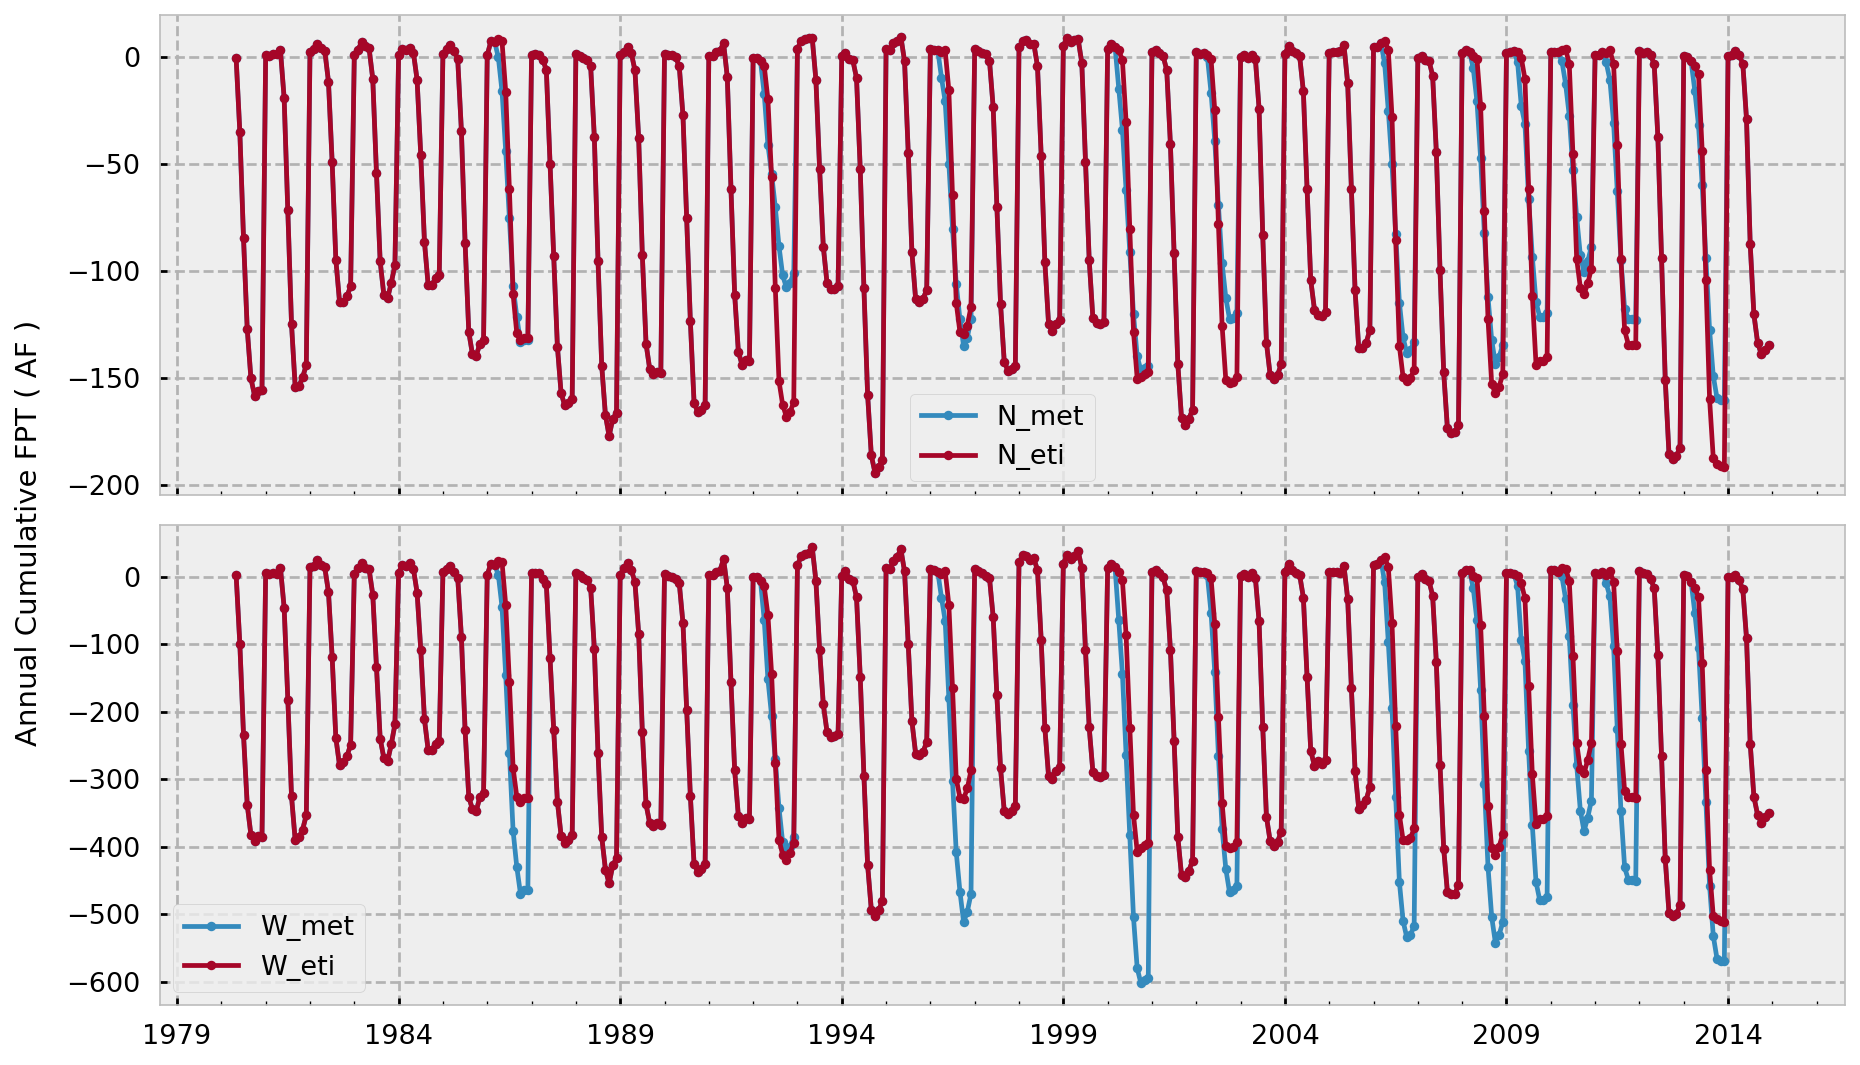

In [271]:
#------------------------------------------------------------------------------
# Fig 3 Monthly Cumulative FPT per year
FPTaccum=pd.merge(FPTnew.groupby(FPTnew.columns.str[0],axis=1).mean().groupby(FPTnew.index.year).cumsum(),
                  FPTold.groupby(FPTold.columns.str[0],axis=1).mean().groupby(FPTold.index.year).cumsum(),
                  left_index=True, right_index=True,
                  suffixes=('_met','_eti'))
fig3,ax3 = plt.subplots(2,1,sharex=True)
FPTaccum.iloc[:,[0,2]].plot(marker='.',ax=ax3[0])
FPTaccum.iloc[:,[1,3]].plot(marker='.',ax=ax3[1])
fig3.text(0.035,0.5,r'Annual Cumulative FPT ( AF )',
         va='center', rotation='vertical',
         fontsize=14)
fig3.tight_layout(rect=(.05,0,1,1))

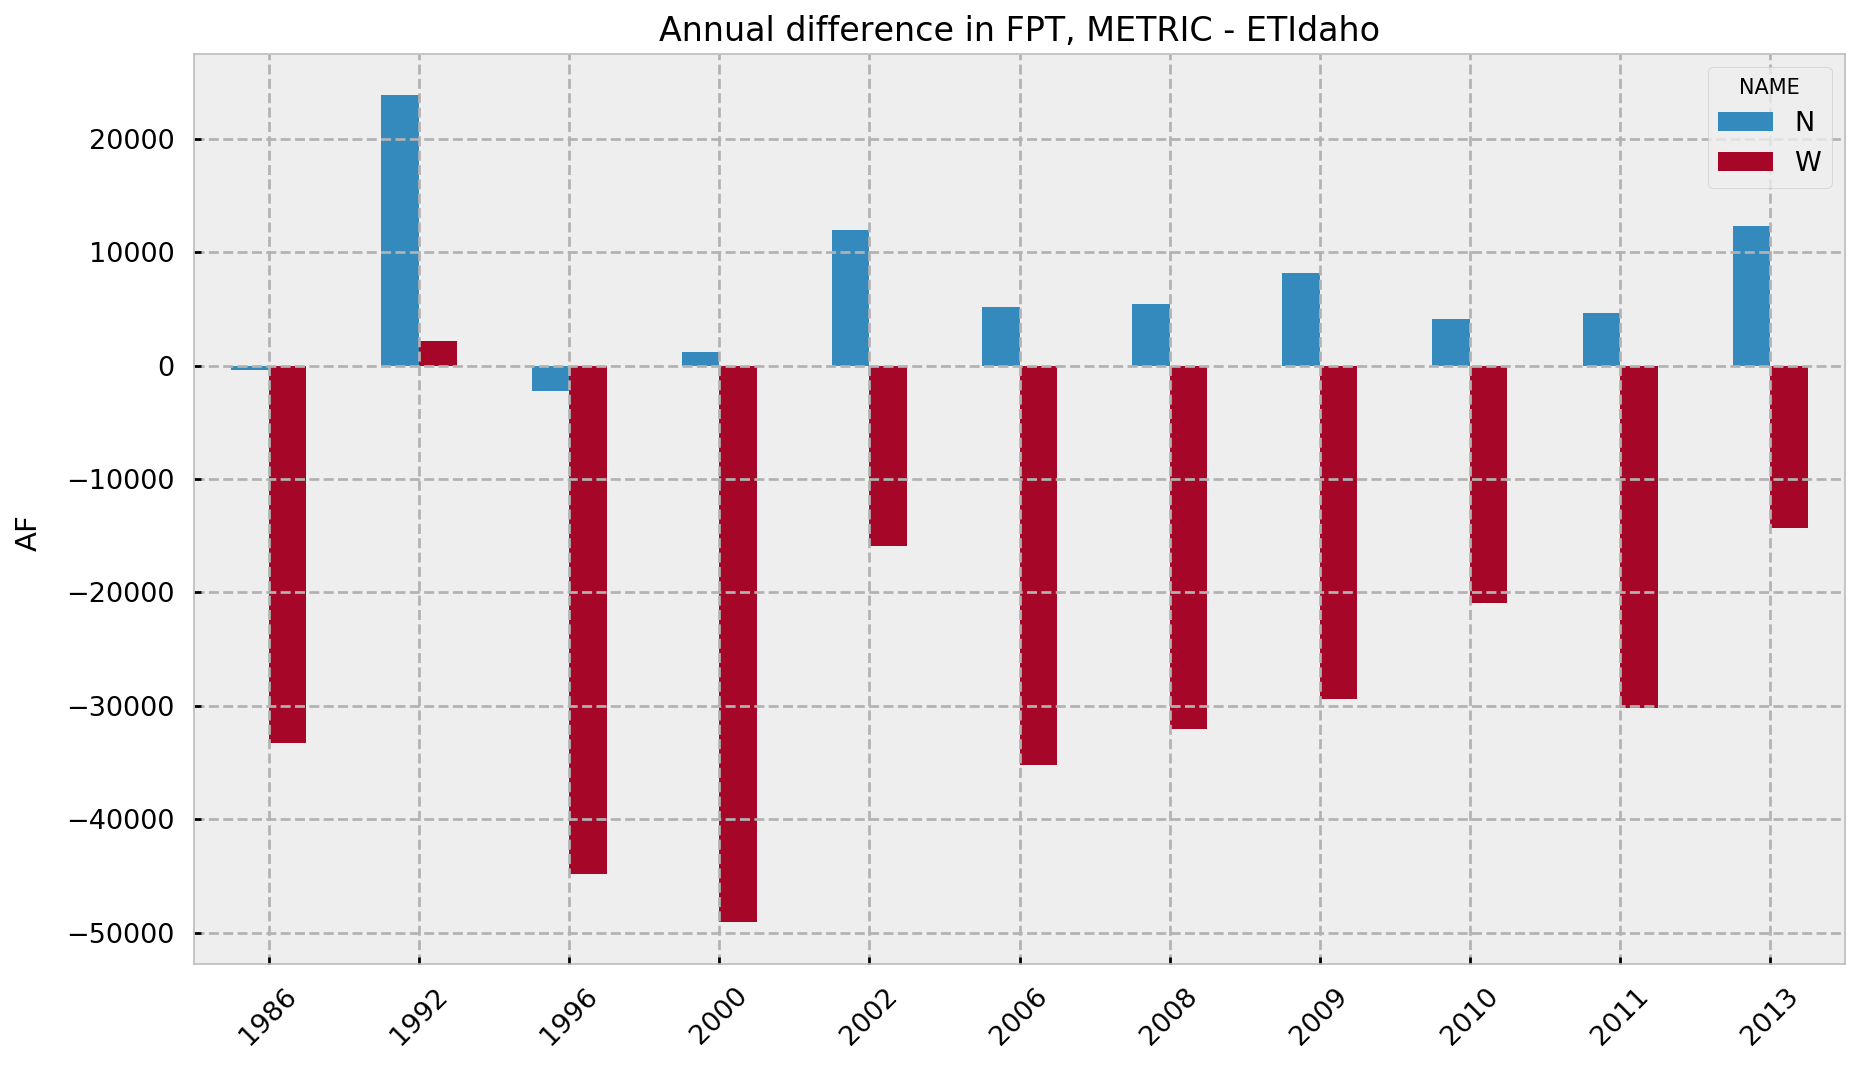

In [15]:
#------------------------------------------------------------------------------
# Fig 4 Annual Difference
FPTnewA = FPTnew.resample('A').sum()
FPToldA = FPTold.resample('A').sum()
#ax4=FPTnewA.sum(axis=1).plot(label='METRIC')
#FPToldA.sum(axis=1).plot(ax=ax3,label='ETI')
#FPToldA.groupby(FPToldA.columns.str[0],axis=1).sum().plot()
FPTdiffA = (FPTnewA - FPToldA).groupby(FPToldA.columns.str[0],axis=1).sum()
FPTdiffA = FPTdiffA.loc[FPTdiffA.index.year.isin(cols.year)]
FPTdiffA.index=FPTdiffA.index.year

# Fig 4: Annual FPT during years with METRIC
fig4,ax4 = plt.subplots(1,1)
FPTdiffA.plot(kind='bar', ax=ax4 )
plt.xticks(rotation=45)
#ax4.text(5,1600000,r'ETI discharge < METRIC recharge',ha='center')
#ax4.text(5,-900000,r'ETI discharge > METRIC discharge',ha='center')
fig4.text(.035,0.5,'AF',
         va='center', rotation='vertical',
         fontsize=14)
plt.title('Annual difference in FPT, METRIC - ETIdaho',fontsize=16)
plt.tight_layout(rect=(.05,0,1,1))

### Peak ET is lower for METRIC, but increases earlier and stays high longer

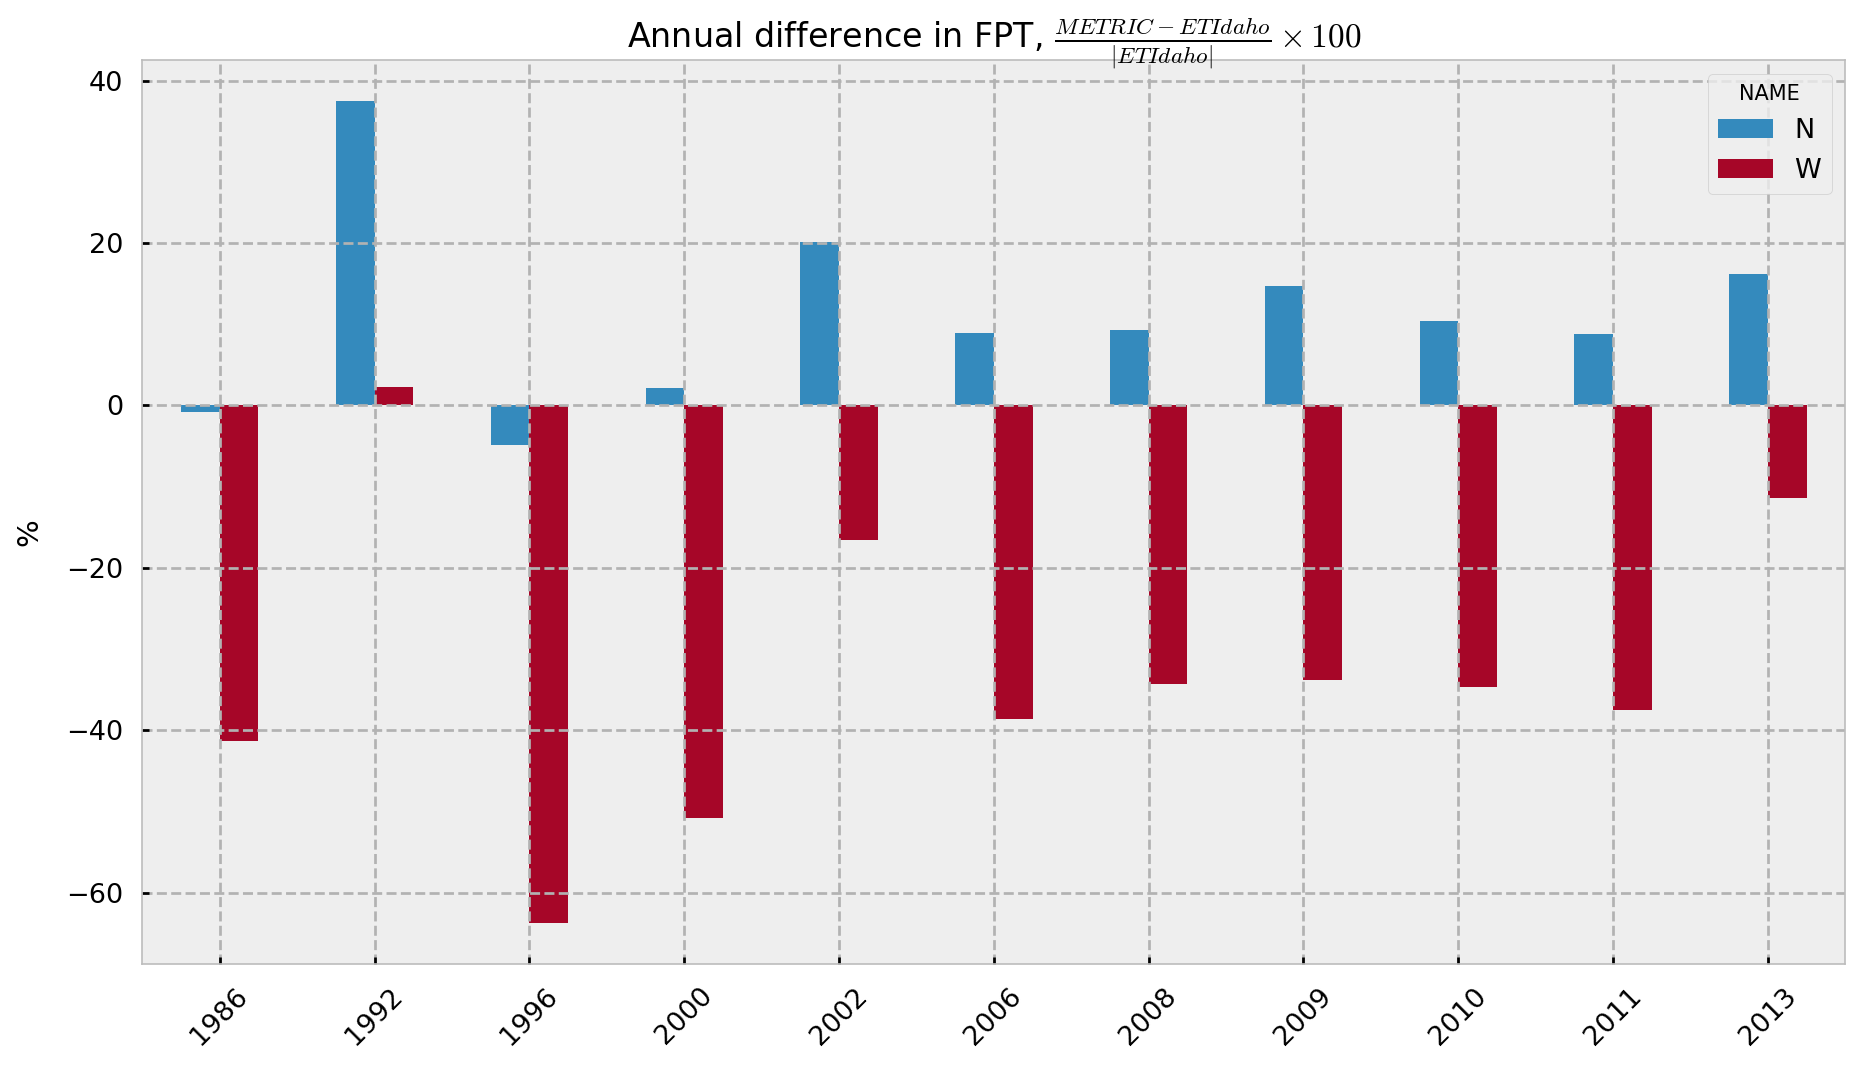

In [16]:
#------------------------------------------------------------------------------
# Fig 4b. Annual % Difference
FPTnewA = FPTnew.resample('A').sum().groupby(FPTnew.columns.str[0],axis=1).sum()
FPToldA = FPTold.resample('A').sum().groupby(FPTold.columns.str[0],axis=1).sum()


FPTpctdiff = (FPTnewA-FPToldA)/FPToldA.apply(np.abs)* 100

FPTpctdiff = FPTpctdiff.loc[FPTpctdiff.index.year.isin(cols.year)]
FPTpctdiff.index=FPTpctdiff.index.year
FPTpctdiff
fig4b,ax4b = plt.subplots(1,1)
FPTpctdiff.plot(kind='bar', ax=ax4b )
plt.xticks(rotation=45)
#ax4.text(5,1600000,r'ETI discharge < METRIC recharge',ha='center')
#ax4.text(5,-900000,r'ETI discharge > METRIC discharge',ha='center')
fig4b.text(.035,0.5,r'%',
         va='center', rotation='vertical',
         fontsize=14)
plt.title(r'Annual difference in FPT, $\frac{METRIC - ETIdaho}{|ETIdaho|}\times100$',fontsize=16)
plt.tight_layout(rect=(.05,0,1,1))


## Resample to annual cumulative FPT by entity and export to shapefile

In [17]:
# Subtract METRIC from ETIdaho estimates for wetland discharge
FPTdiff_ents = FPTnew.resample('A').sum() - FPTold.resample('A').sum()
# Extract only overlapping years
FPTdiff_ents = FPTdiff_ents.loc[FPTdiff_ents.index.year.isin(cols.year)].T
FPTdiff_ents.columns = FPTdiff_ents.columns.year.astype(str)


In [384]:
'+proj=tmerc +lat_0=42 +lon_0=-114 +k=0.9996 +x_0=2500000 +y_0=1200000 +ellps=GRS80 +units=m +no_defs'
dfout.to_file(r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\Shapefiles\WetlandsFPT_metric_less_eti.shp')

In [18]:
# Merge the wetlands shapefile dataframe (dfMETRICbase) with the yearly differences. Export to shapefile
dfwetlands = gpd.GeoDataFrame.from_file(r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\Shapefiles\WetlandsPolygons\WetlandsPolygons.shp')
dfout = FPTdiff_ents.reset_index().merge(dfwetlands,
                           left_on='NAME',
                           right_on='FPT_NAME')

dfout = gpd.GeoDataFrame(dfout,geometry='geometry',crs=dfwetlands.crs);

#dfout.plot(column=2000,scheme='Fisher_Jenks',cmap='RdYlBu');
#dfout[1996].plot(kind='box')

# ---- Get 5th percentile for each year
FPTp10 = FPTdiff_ents[FPTdiff_ents  <= FPTdiff_ents.quantile(.05)].dropna(how='all')
d = {}
for year in FPTp10.columns:
    d[year]=FPTp10[year].dropna().sort_values().index.values
FPTp10cells=pd.DataFrame(d)
#[print('NAME = \'{}\' OR '.format(c),end="") for c in FPTp10cells[1986].tolist()]
# Count number of times cell makes it into the 5th percentile and add to dataframe
a = FPTp10cells.unstack().value_counts()
a.name = 'p5_count'
dfout.index = dfout.NAME
dfout = dfout.merge(pd.DataFrame(a), how='outer', left_index=True, right_index=True)
#dfout.loc[ dfout['p5_count'].isnull(),'p5_count' ] = 0
dfout = gpd.GeoDataFrame(dfout,geometry='geometry',crs=dfwetlands.crs);
#dfout.to_file(r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\Shapefiles\WetlandsFPT_metric_less_eti.shp')

![caption](.\FPT\Wetlands\fig\Wetlands_p5_counts_01.png)

![caption](.\FPT\Wetlands\fig\Wetlands_p5_counts_02.png)

![caption](.\FPT\Wetlands\fig\Wetlands_p5_counts_03.png)

![caption](.\FPT\Wetlands\fig\Wetlands_p5_counts_04.png)

### American Falls, 2017
<img src=".\FPT\Wetlands\fig\AF_openwater_2017.png" width="800">

### American Falls, 1992
<img src=".\FPT\Wetlands\fig\AF_openwater_1992.png" width="800">

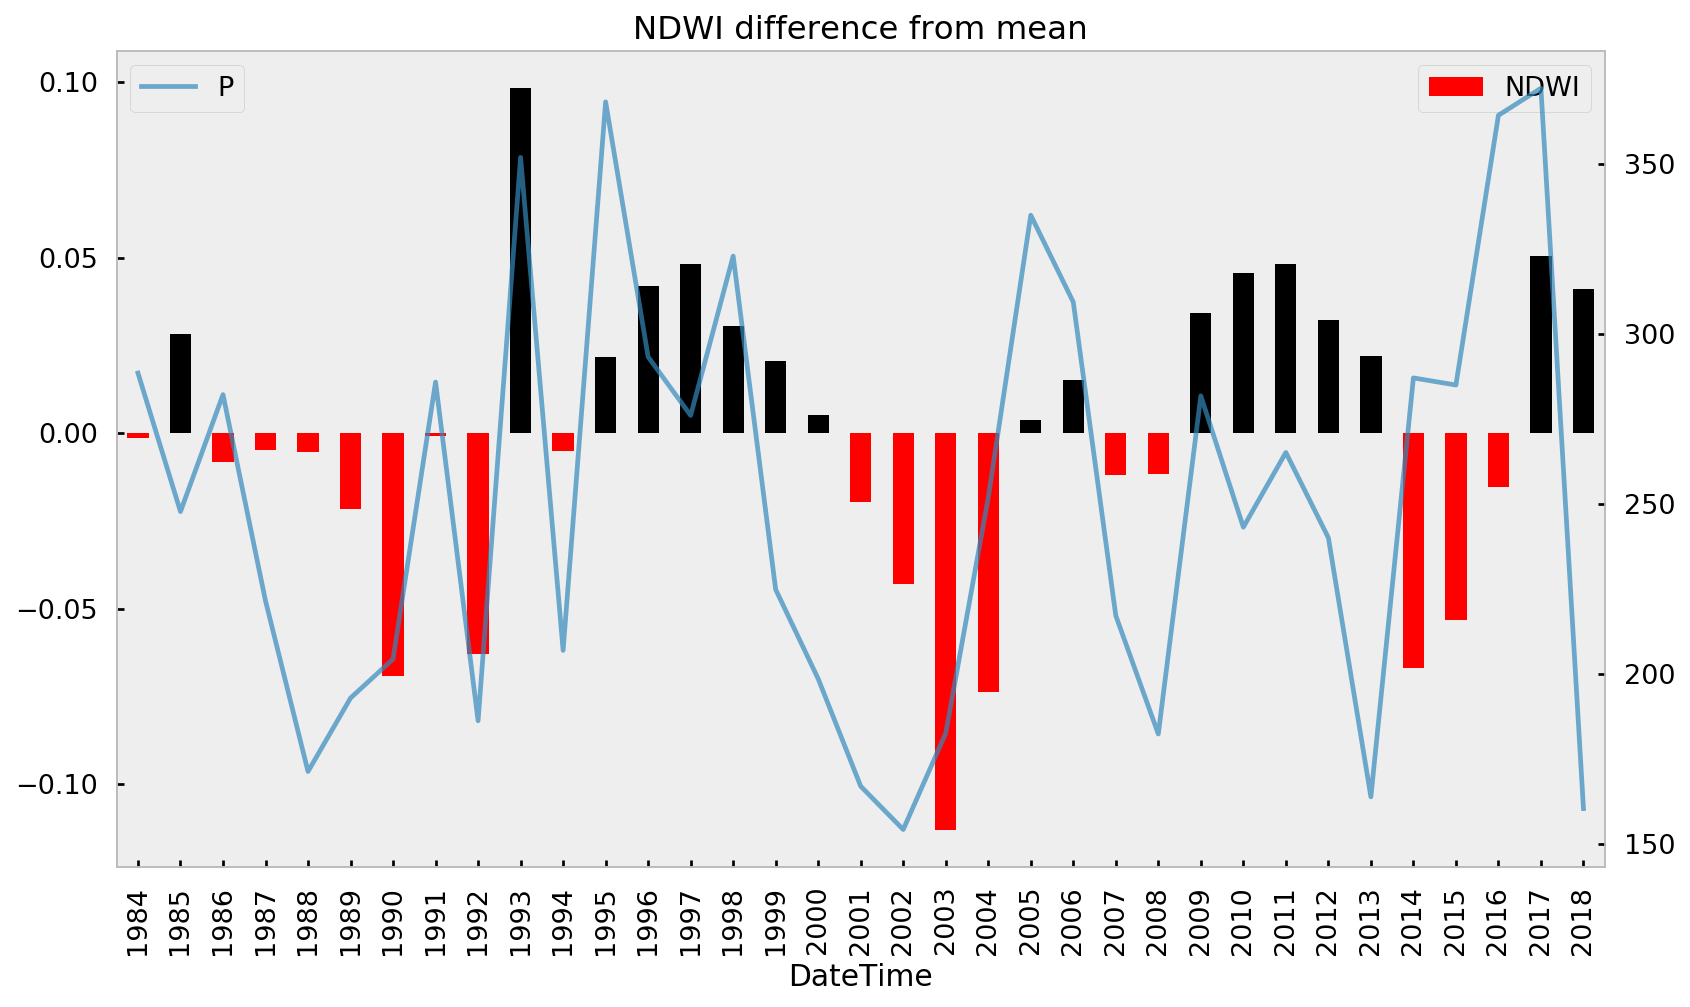

In [19]:
dfNDWI = pd.read_csv(r'D:/ESRP/RechargeData_Alex/FPT/Wetlands/ndwi_vs_ppt.csv',index_col=0,parse_dates=True)
dfNDWI.columns = ['NDWI', 'P']
dfNDWI.index = dfNDWI.index.year.astype(str)
data = dfNDWI['NDWI']-dfNDWI['NDWI'].mean()
colors={1:'k',-1:'r'}

figNDWI,axNDWI = plt.subplots(1,1)
data.plot(kind='bar',color=[colors[i] for i in np.sign(data)],ax=axNDWI)
axPPT = axNDWI.twinx()
axPPT.plot(dfNDWI['P'],alpha=0.7)
axNDWI.legend()
axNDWI.grid(False)
axPPT.grid(False)
axPPT.legend();
plt.title('NDWI difference from mean');


False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

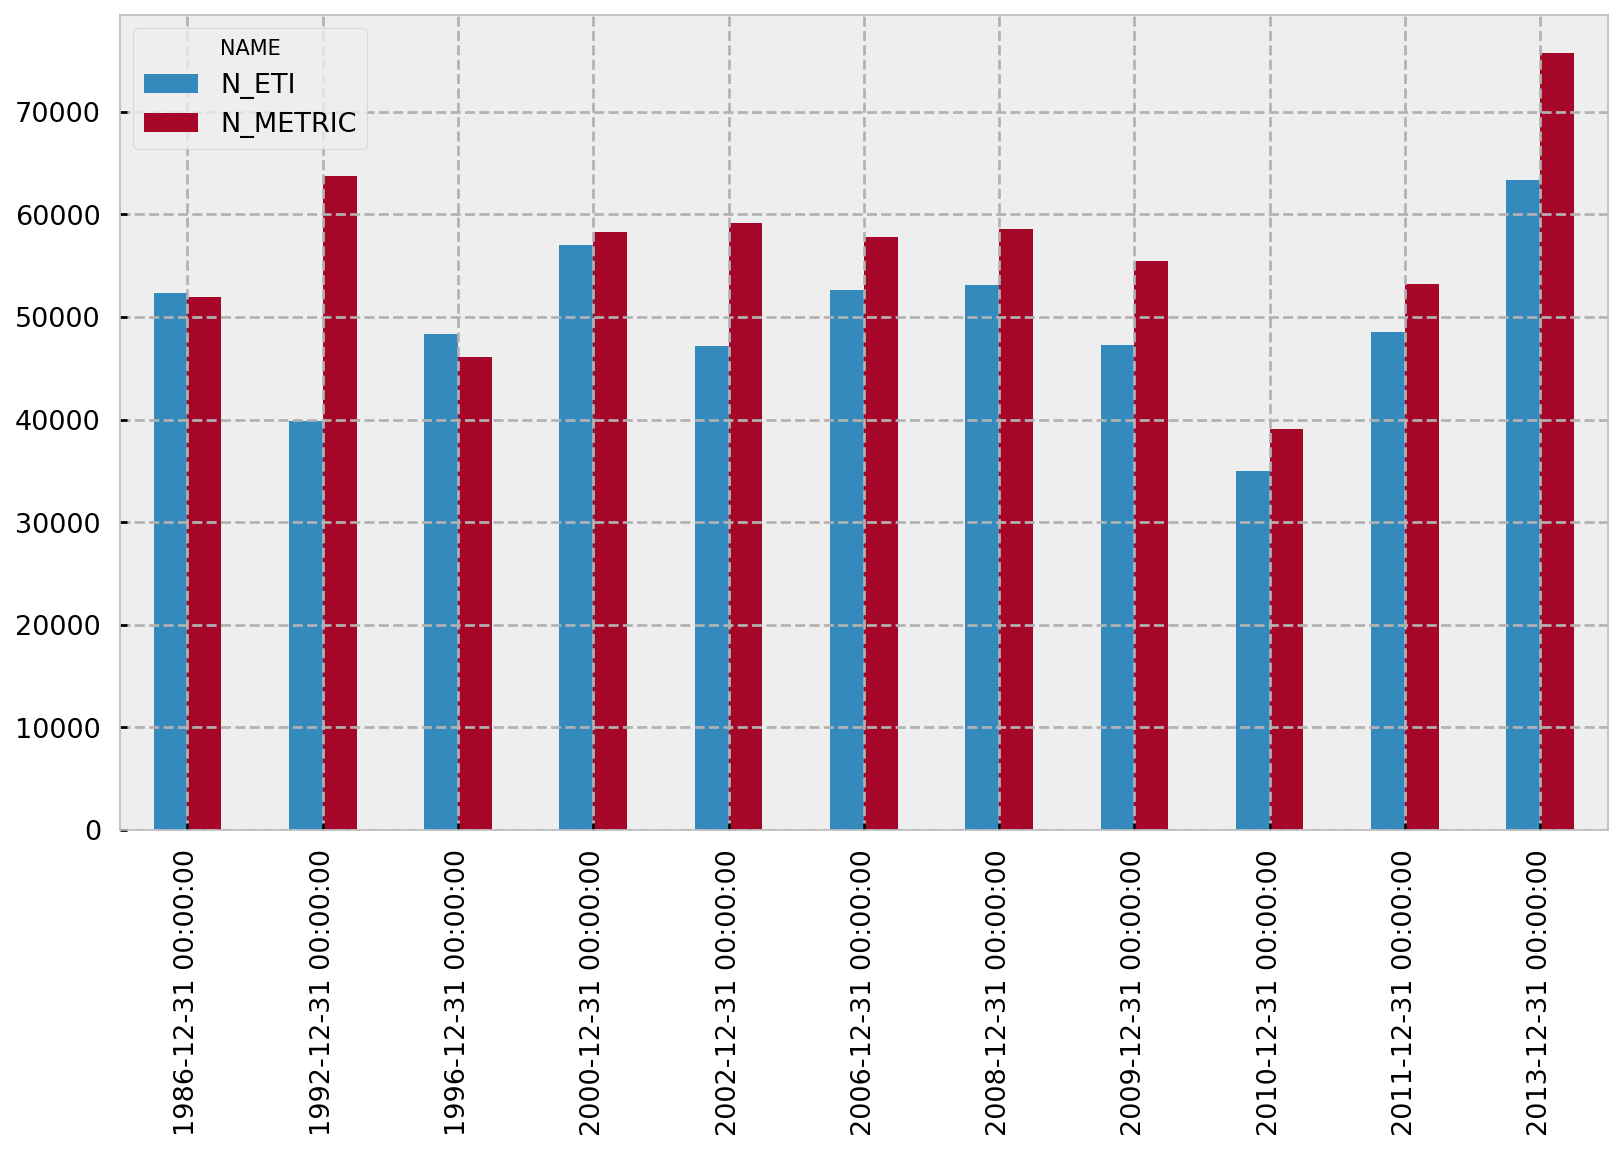

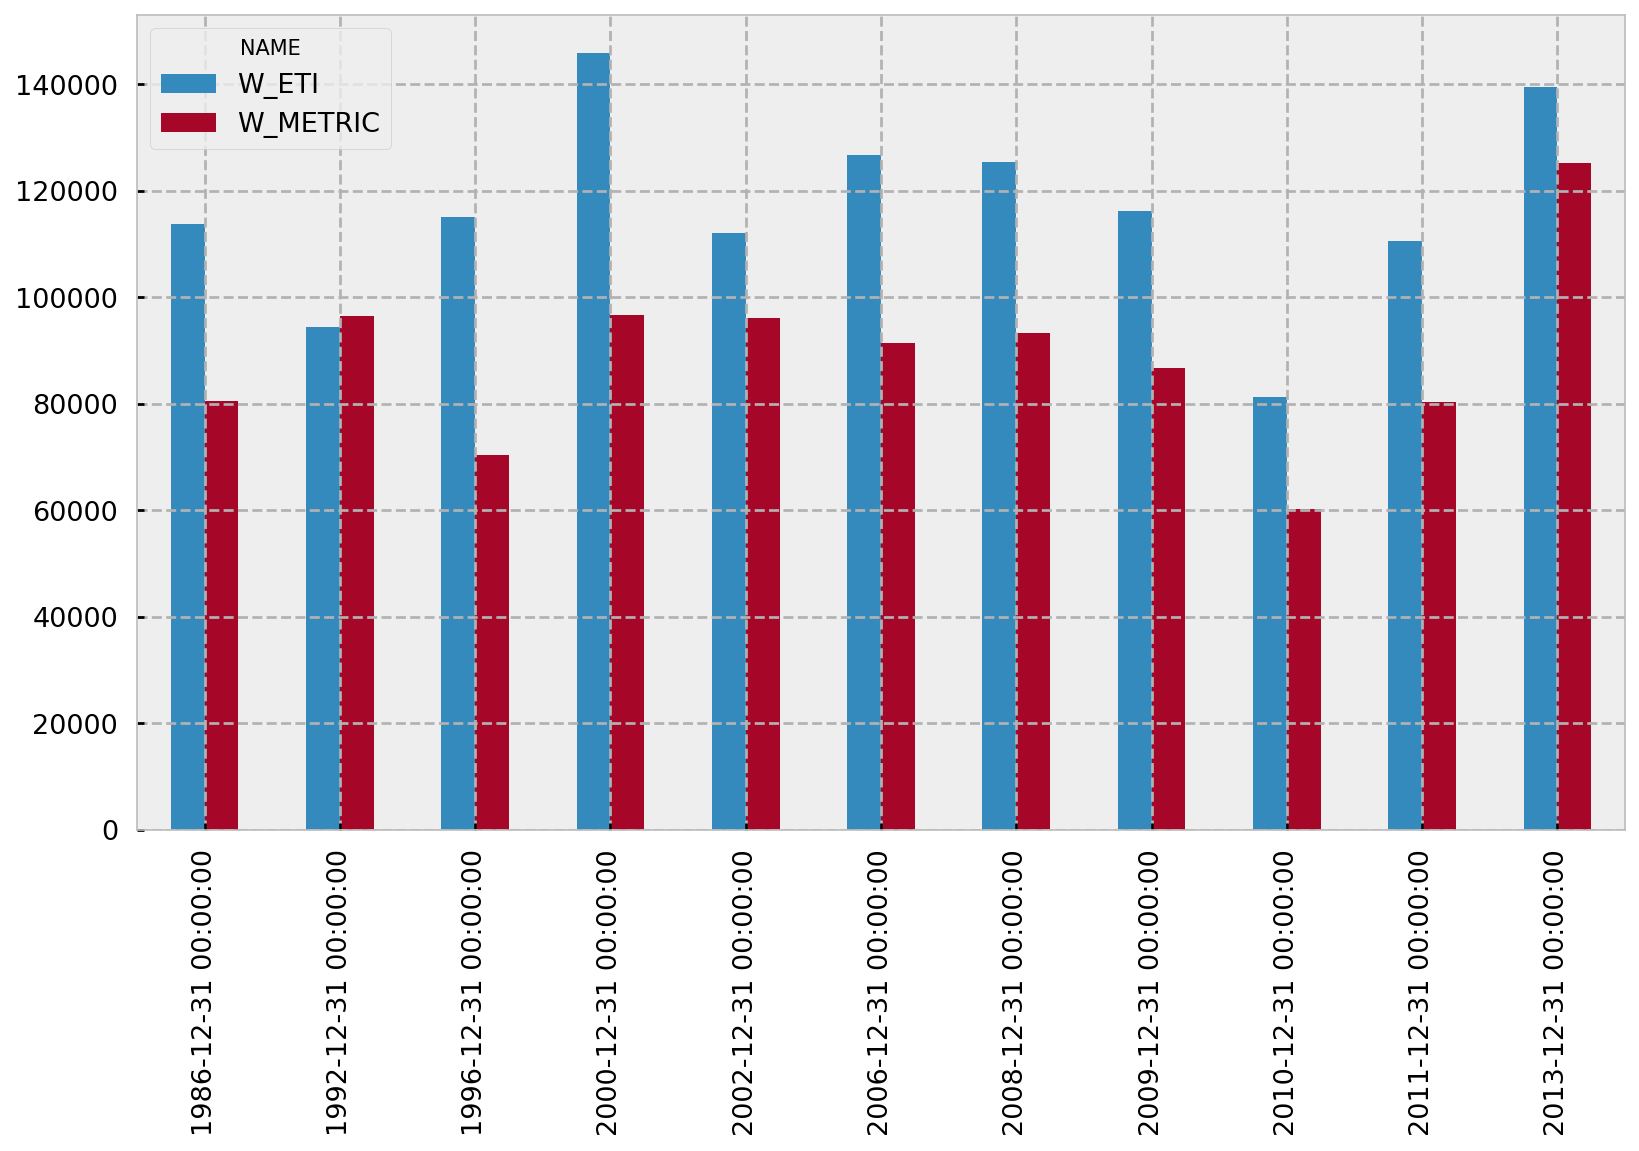

In [34]:
FPTA=FPTnewA.groupby(FPTnew.columns.str[0],axis=1).sum().merge(
    FPToldA.groupby(FPTold.columns.str[0],axis=1).sum(),
    right_index=True,left_index=True,
    suffixes=('_ETI','_METRIC'))
FPTA = FPTA.loc[FPTA.index.year.isin(cols.year)]
FPTA.mul(-1).groupby(FPTA.columns.str.contains('W'),axis=1).plot(kind='bar',sharey=True)

# ARIMA models vs. monthly averages

In [ ]:
#---------
# ARIMA
# --------
# Load ARIMA dictionary
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from load_idwr import parse_ETIDAHO_monthly
import pickle
# Load ETIdaho data
f=r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\ETIdaho\WetlandsETIdaho_201612.csv'
dfETI = pd.read_csv(f,header=[0,1,2],index_col=0,parse_dates=True)
# Load model results
with open('D:/ESRP/RechargeData_Alex/FPT/Wetlands/ETIdaho_ARIMA_gridsearch_results.pkl','rb') as f:
    dARIMA = pickle.load(f)
    
def ForecastTS( data , ARIMAparams ):
    # Scale Data
    scaler = StandardScaler()
    scaler.fit(data.dropna().values.reshape(-1,1))
    datanorm = data.dropna().apply(lambda x: scaler.transform(x)[0][0])
    datanorm = datanorm.resample('MS').asfreq()
    # Run model
    mod = sm.tsa.statespace.SARIMAX(datanorm,
                                    order= ARIMAparams[0],
                                    seasonal_order=ARIMAparams[1],
                                    enforce_stationarity=False,
                                    enforce_intertibility=True)
    results=mod.fit()
    # Make predictions
    datapred = results.predict(start = data.first_valid_index() , end= pd.datetime(2017,9,1))
    datapred = pd.Series( scaler.inverse_transform( datapred ), 
                         index = datapred.index,
                         name='predict')
    # Remove negative ET, replace with min of real data
    datapred = datapred.where(datapred > 0 , data.min())
    
    # Place predicted data where data is NAN
    data = pd.concat([data,datapred],axis=1) 
    data = data.iloc[:,0].where(np.isfinite(data.iloc[:,0] ),data['predict'])
   
    return datapred
    
      
ET_RMSE = {}
rmse = lambda x,y: round(np.sqrt(mean_squared_error(x,y)),2)
for key in dARIMA.keys():
    #print('Running {} {} ARIMA'.format(key[0],key[1]))
    data = dfETI.loc[:,key[0:2]].squeeze()
    datapred = ForecastTS(data, dARIMA[key[0:2]]['Params'])
    alldata = pd.concat([data,datapred],axis=1)
    alldata = alldata['1980-1-1':]
    monthmean = data.groupby(data.index.month).mean()
    alldata['mean']=alldata.index.month.map(monthmean.to_dict())
    ET_RMSE[key] = pd.Series({'SARIMA':rmse(alldata.dropna().iloc[:,0],alldata.dropna().loc[:,'predict']),
           'mean': rmse(alldata.dropna().iloc[:,0],alldata.dropna().loc[:,'mean']) } )
    # Plot Forecast

df = pd.concat(ET_RMSE,axis=1)

# Water budget components

In [20]:
#MKMOD HTML TABLES
import pickle
with open(r'D:/ESRP/RechargeData_Alex/MKMOD_2x/ESPAM2x_201709.pkl','rb') as f:
    dMKMOD = pickle.load(f)
df = dMKMOD['Table 2']

In [21]:
df.columns.tolist()
df.filter(regex='Trib|Perch|Rate\(inches\)|Canal|Excess')

Non-Irrigated Land Groundwater Irrigated Land  \
                 Rate(inches)    ApplicationRate(inches)   
1980-05-01               0.63                       2.58   
1980-06-01               0.11                       7.58   
1980-07-01               0.07                       9.38   
1980-08-01               0.10                       4.90   
1980-09-01               0.19                       1.70   
1980-10-01               0.07                       0.83   
1980-11-01               0.08                       0.01   
1980-12-01               0.02                       0.16   
1981-01-01               0.02                       0.02   
1981-02-01               0.28                       0.49   
1981-03-01               0.14                       0.32   
1981-04-01               0.22                       1.71   
1981-05-01               0.38                       3.59   
1981-06-01               0.04                       8.30   
1981-07-01               0.02                      10.24   
1981-08-01               0.01                       5.83   
1981-09-01               0.02                       2.10   
1981-10-01               0.16                       0.37   
1981-11-01               0.29                       0.01   
1981-12-01               0.05                       0.00   
1982-01-01               0.02                       0.00   
1982-02-01               0.63                       0.11   
1982-03-01               0.26                       0.22   
1982-04-01               0.13                       1.42   
1982-05-01               0.13                       3.66   
1982-06-01               0.14                       7.16   
1982-07-01               0.14                       8.22   
1982-08-01               0.07                       6.50   
1982-09-01               0.18                       1.77   
1982-10-01               0.19                       0.25   
...                       ...                        ...   
2015-04-01               0.02                       3.02   
2015-05-01               0.50                       3.35   
2015-06-01               0.01                       9.19   
2015-07-01               0.08                      11.64   
2015-08-01               0.03                       6.21   
2015-09-01               0.04                       5.31   
2015-10-01               0.10                       2.68   
2015-11-01               0.13                       0.10   
2015-12-01               0.19                       0.01   
2016-01-01               0.12                       0.00   
2016-02-01               0.00                       1.05   
2016-03-01               0.20                       0.07   
2016-04-01               0.09                       2.33   
2016-05-01               0.19                       5.19   
2016-06-01               0.00                       9.37   
2016-07-01               0.00                      12.35   
2016-08-01               0.00                       6.68   
2016-09-01               0.22                       3.54   
2016-10-01               0.51                       0.60   
2016-11-01               0.00                       0.98   
2016-12-01               0.26                       0.00   
2017-01-01               0.32                       0.00   
2017-02-01               0.35                       0.00   
2017-03-01               0.06                       0.99   
2017-04-01               0.18                       1.52   
2017-05-01               0.06                       6.07   
2017-06-01               0.08                       8.54   
2017-07-01               0.01                      12.16   
2017-08-01               0.01                       6.66   
2017-09-01               0.19                       3.90   

           Surface Water Irrigated Land                       \
                       CanalSeepage(af) IrrigationExcess(af)   
1980-05-01                     455016.0             499424.0   
1980-06-01                     534394.

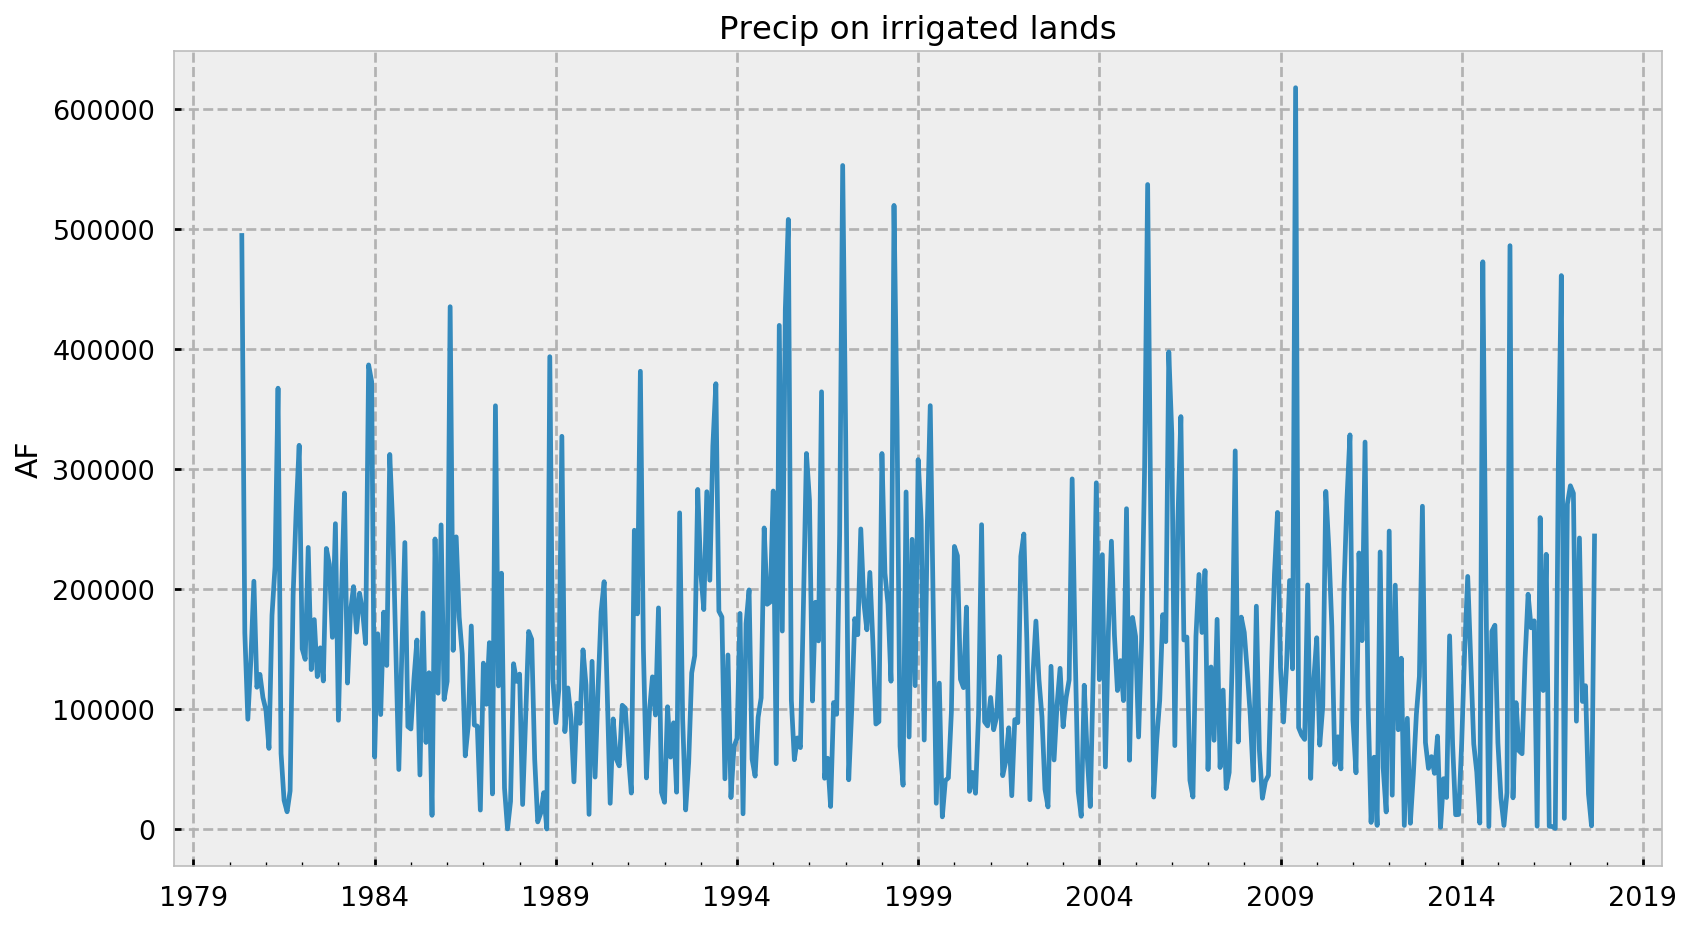

In [22]:
# Precip on irrigated lands
(df.filter(regex='ET\(af\)').sum(axis=1)-df.filter(regex='CIR\(af\)').sum(axis=1)).plot(title='Precip on irrigated lands');
plt.ylabel('AF');

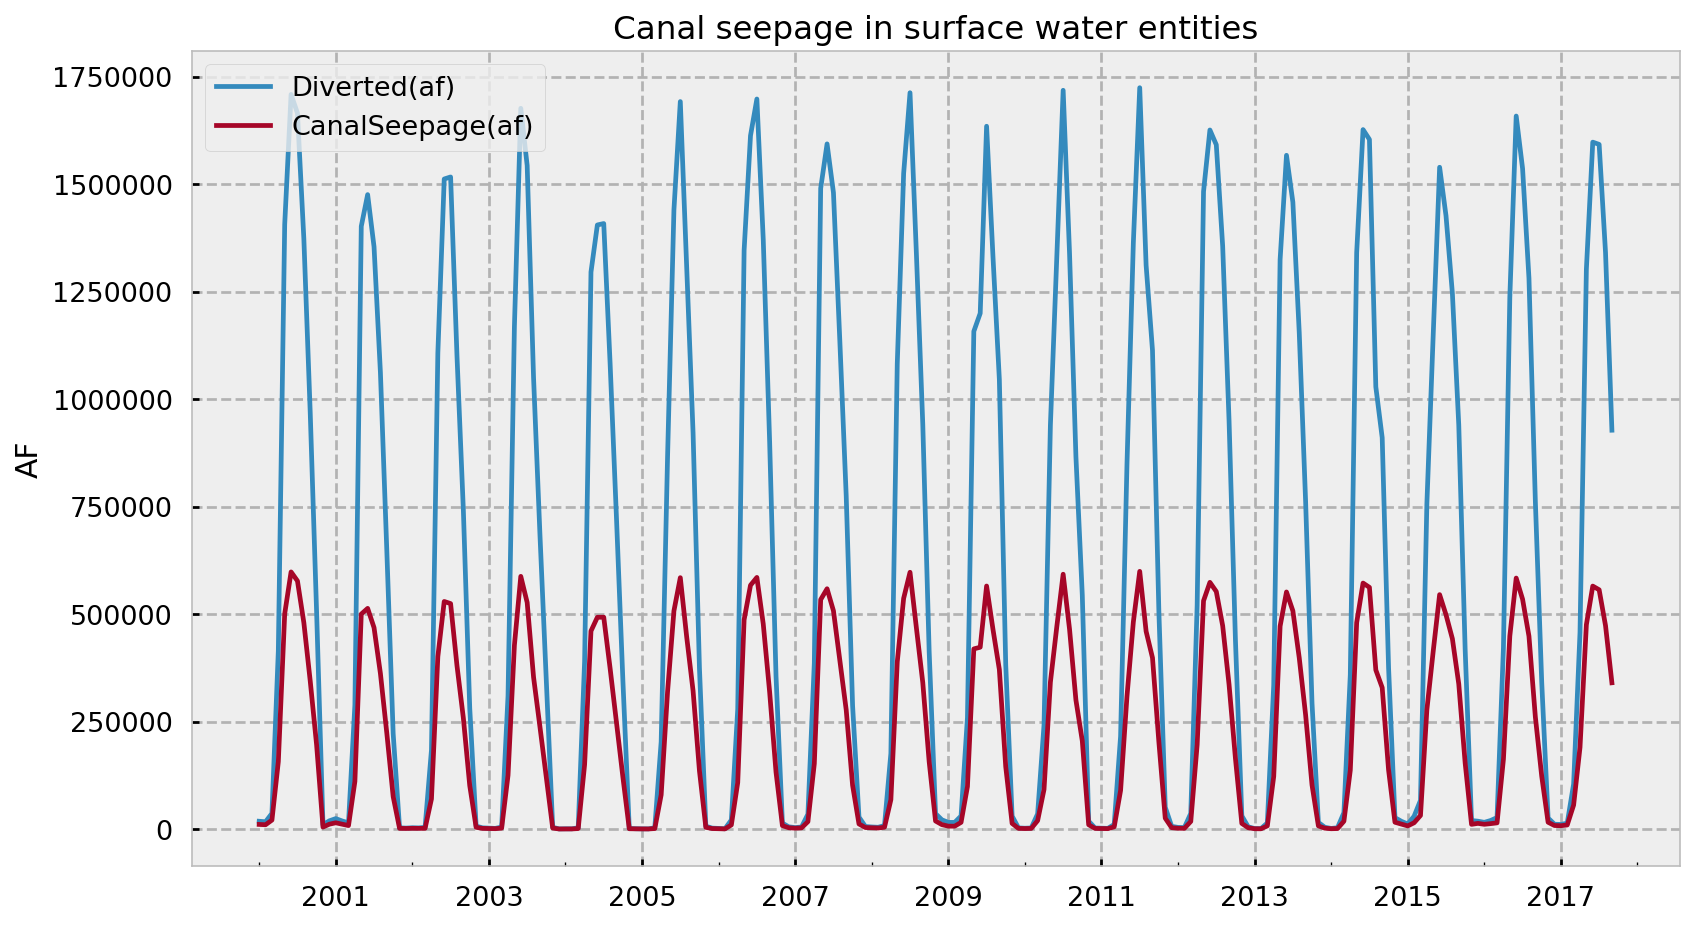

In [23]:

dfSW = df.groupby(level=0,axis=1).get_group('Surface Water Irrigated Land')
dfSW.columns = dfSW.columns.droplevel(0)
figDIV,axDIV = plt.subplots(1,1)
dfSW.filter(regex='Divert|Canal')['2000-1-1':].plot(ax=axDIV,title='Canal seepage in surface water entities');
axDIV.legend(loc='upper left');
plt.ylabel('AF');

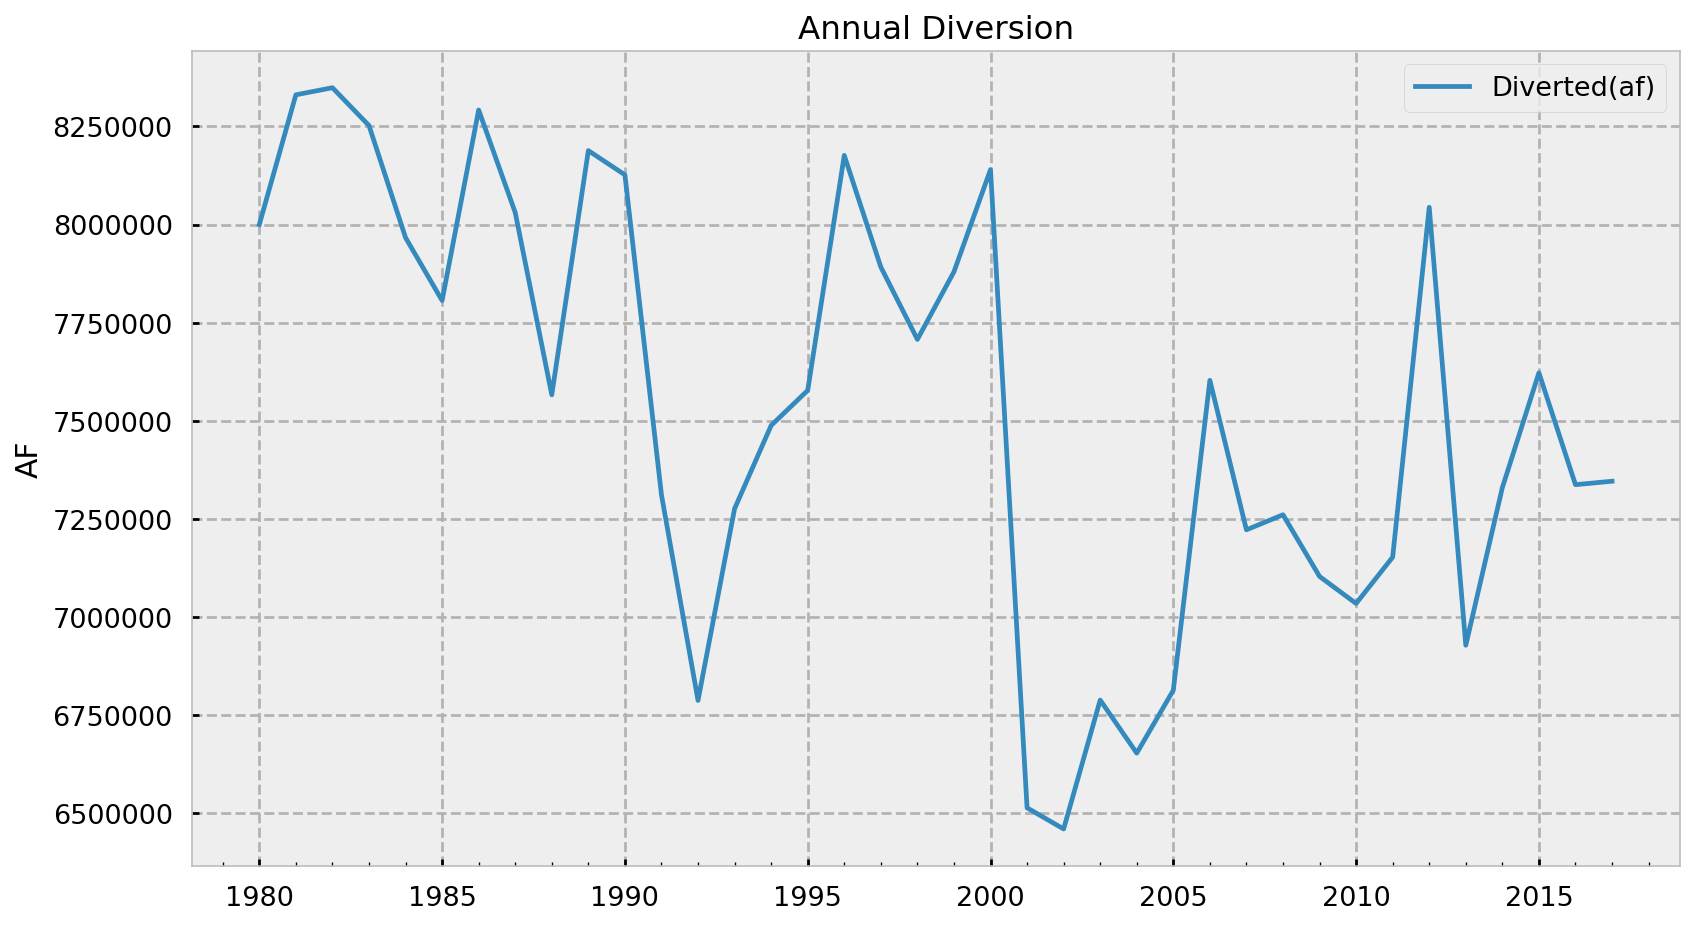

In [24]:
dfSW.filter(regex='Divert').resample('A').sum().plot(title='Annual Diversion');
plt.ylabel('AF');

In [75]:
f = os.path.join(root,'DIV','ESPAM22_DIVS_WORK_FILE_20180216.xlsx') 
d= {}
with pd.ExcelFile(f) as xls:
    sheets = xls.sheet_names
    print('Reading...',end='')
    for sheet in sheets:
        if 'IESW' in sheet:
            print('{},'.format(sheet),end='')
            df = xls.parse(sheet, nrows= 42, usecols =12,header= None ) 
            df.iloc[3:,1:] = df.iloc[3:,1:].astype(float)
            df2 = pd.DataFrame(data = df.iloc[3:,1:].values,
                               index=df.iloc[3:,0],
                               columns=df.iloc[2,1:].values)
            df2 = df2.T.unstack()
            df2.index = [pd.datetime.strptime(x[0][-4:]+x[1],'%Y%b') for x in df2.index.tolist()]
            d[sheet] = df2
                
xls.close() 
df = pd.concat(d,axis=1)
df.where(df >= 0,inplace=True)

Reading...IESW000,IESW001,IESW002,IESW005,IESW008,IESW009,IESW010,IESW011,IESW012,IESW014,IESW015,IESW016,IESW018,IESW019,IESW020,IESW022,IESW025,IESW027,IESW028,IESW029,IESW030,IESW032,IESW034,IESW035,IESW036,IESW037,IESW038,IESW039,IESW040,IESW044,IESW051,IESW052,IESW053,IESW055,IESW056,IESW057,IESW058,IESW060,IESW061,IESW062,IESW063,

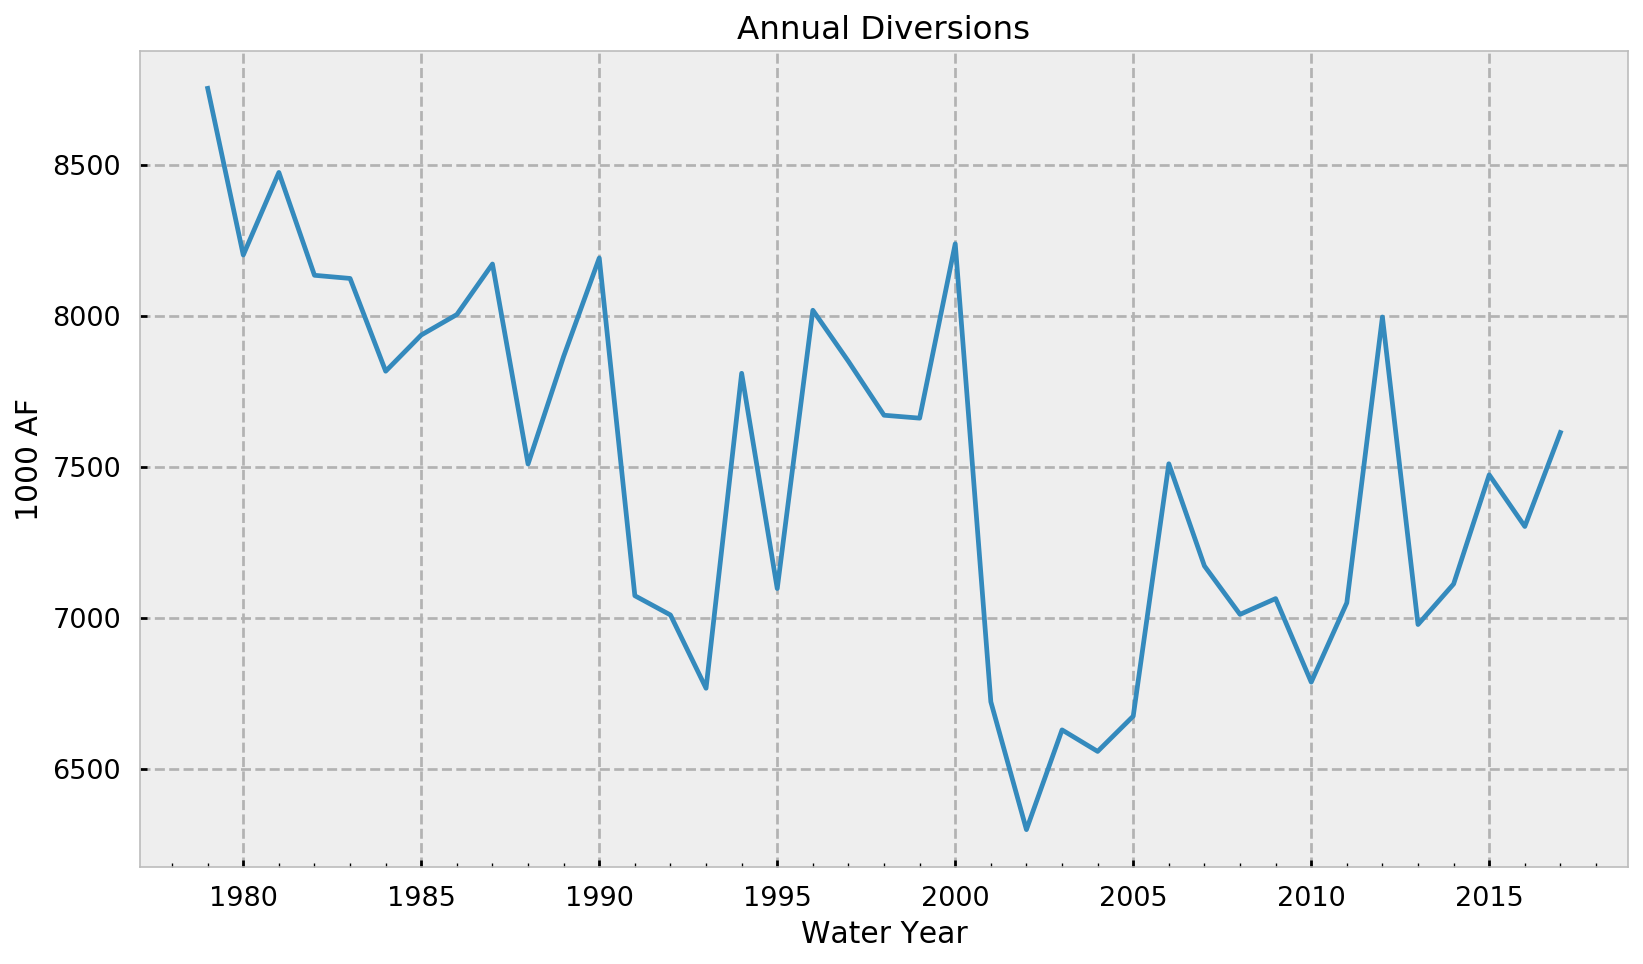

In [76]:
axDIV = df.sum(axis=1).resample('A').sum().plot()
axDIV.set_ylabel('1000 AF');
axDIV.set_xlabel('Water Year');
plt.title('Annual Diversions');

## Non-Snake perched river seepage

In [25]:
f = os.path.join(root,'PCH','ESPAM22_PerchedRivSeep_201709.xlsx')
df = pd.read_excel(f ,sheet_name='ALL',header=[2,3],index_col=[0,1],parse_dates=True)
df.columns = df.columns.droplevel(1)
df.index = df.index.droplevel(1)
df = df.T
df = df.div(43560)# Convert to AF

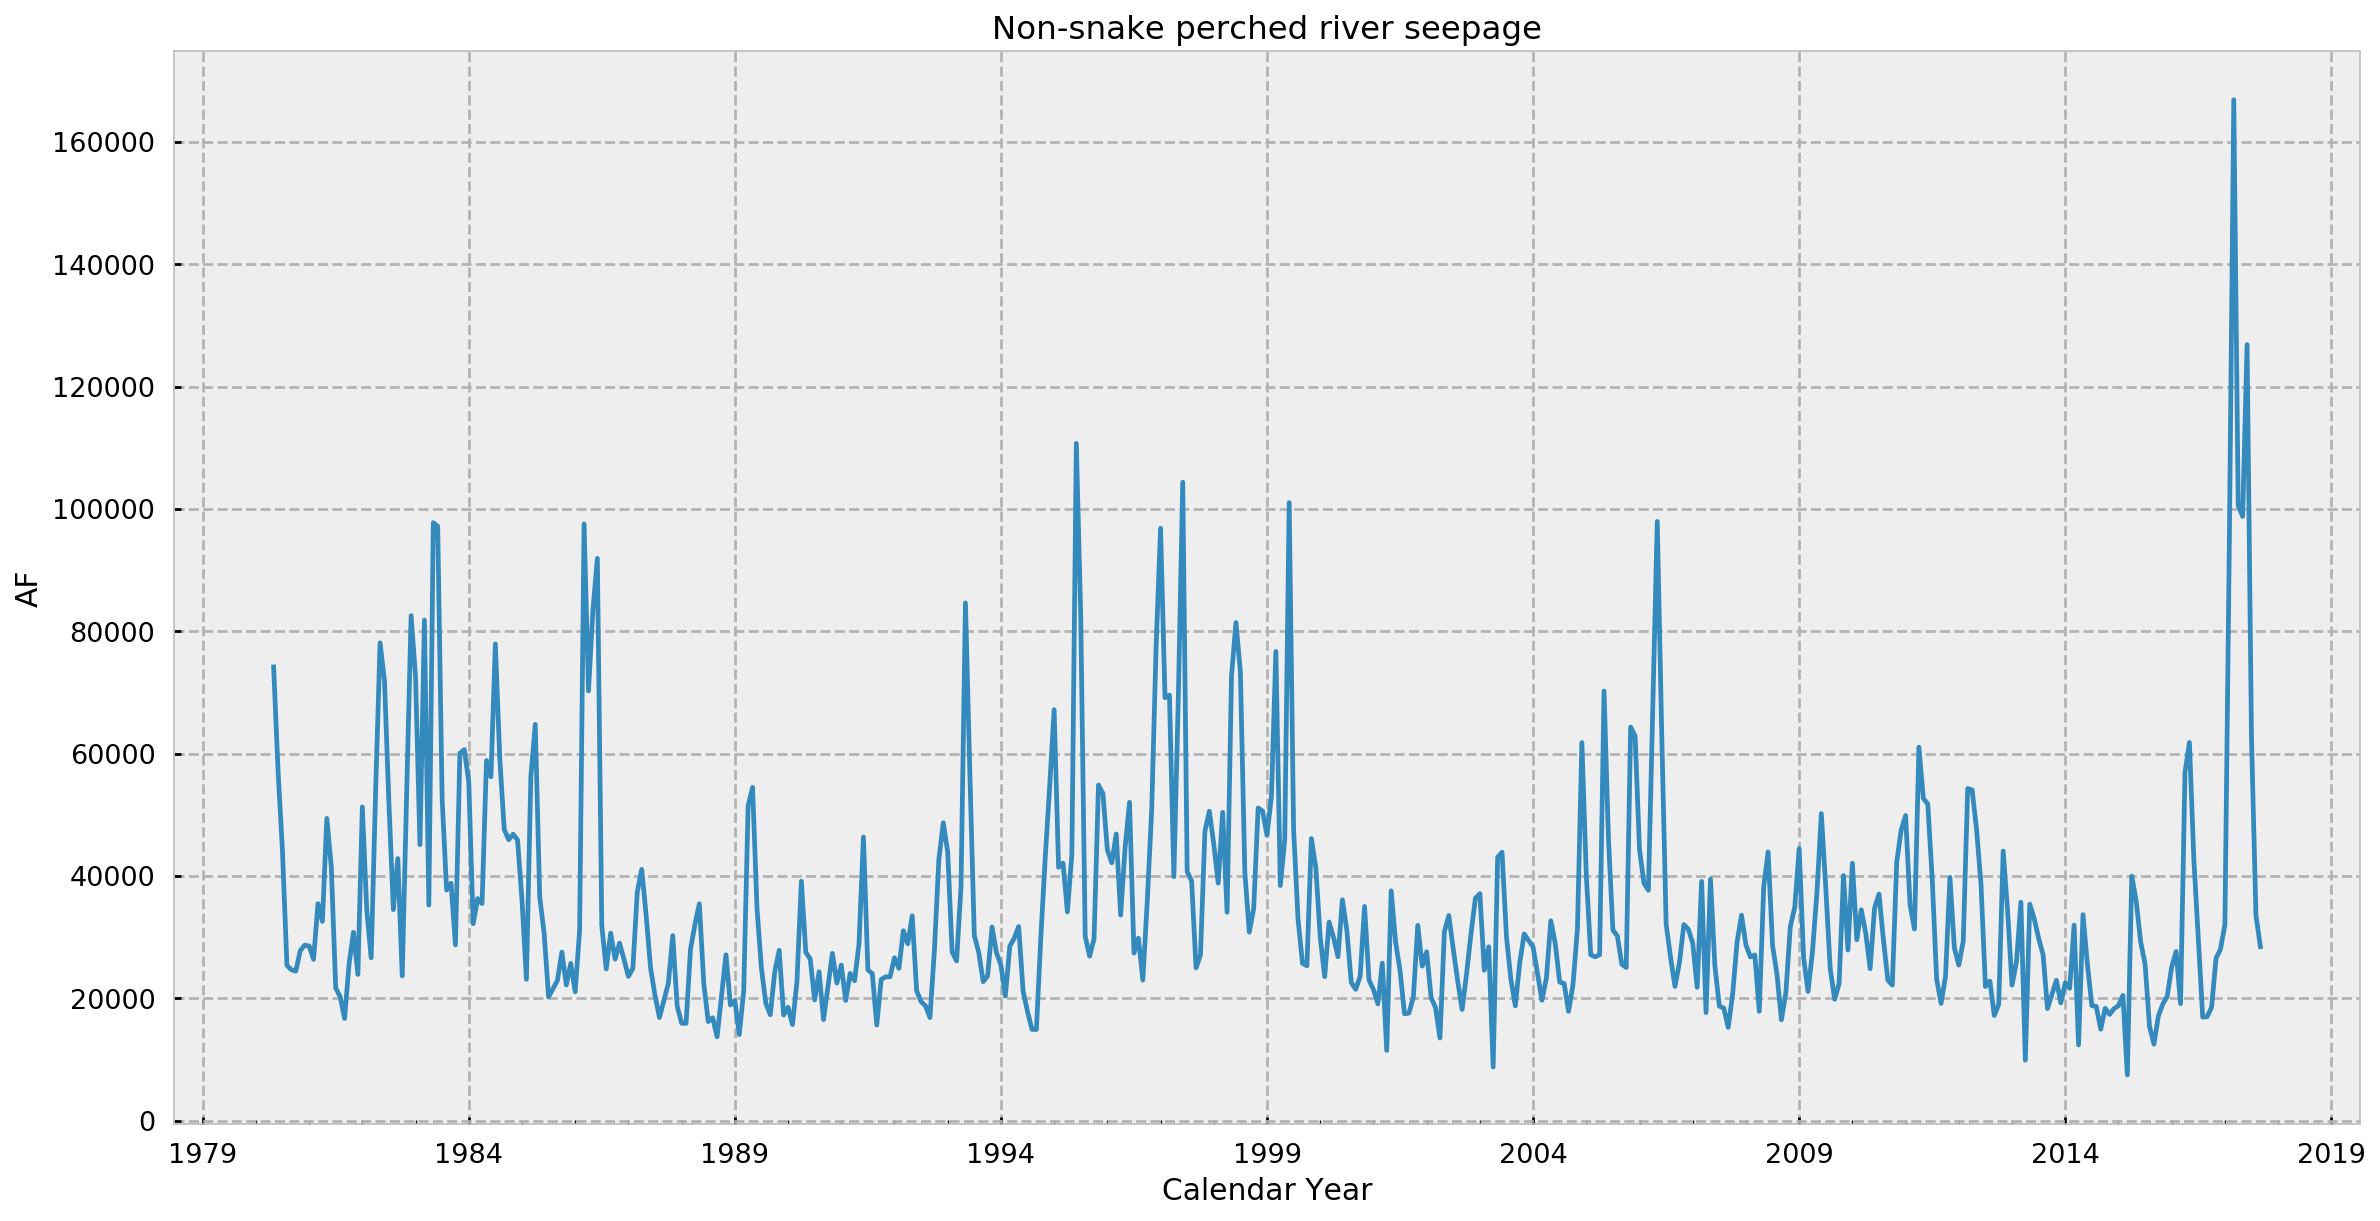

In [26]:
figPCH,axPCH = plt.subplots(1,1,figsize=(16,8))
df.sum(axis=1).plot(ax=axPCH)
axPCH.set_ylabel(r'AF')
axPCH.set_xlabel('Calendar Year')
figPCH.tight_layout()
axPCH.set_title('Non-snake perched river seepage');

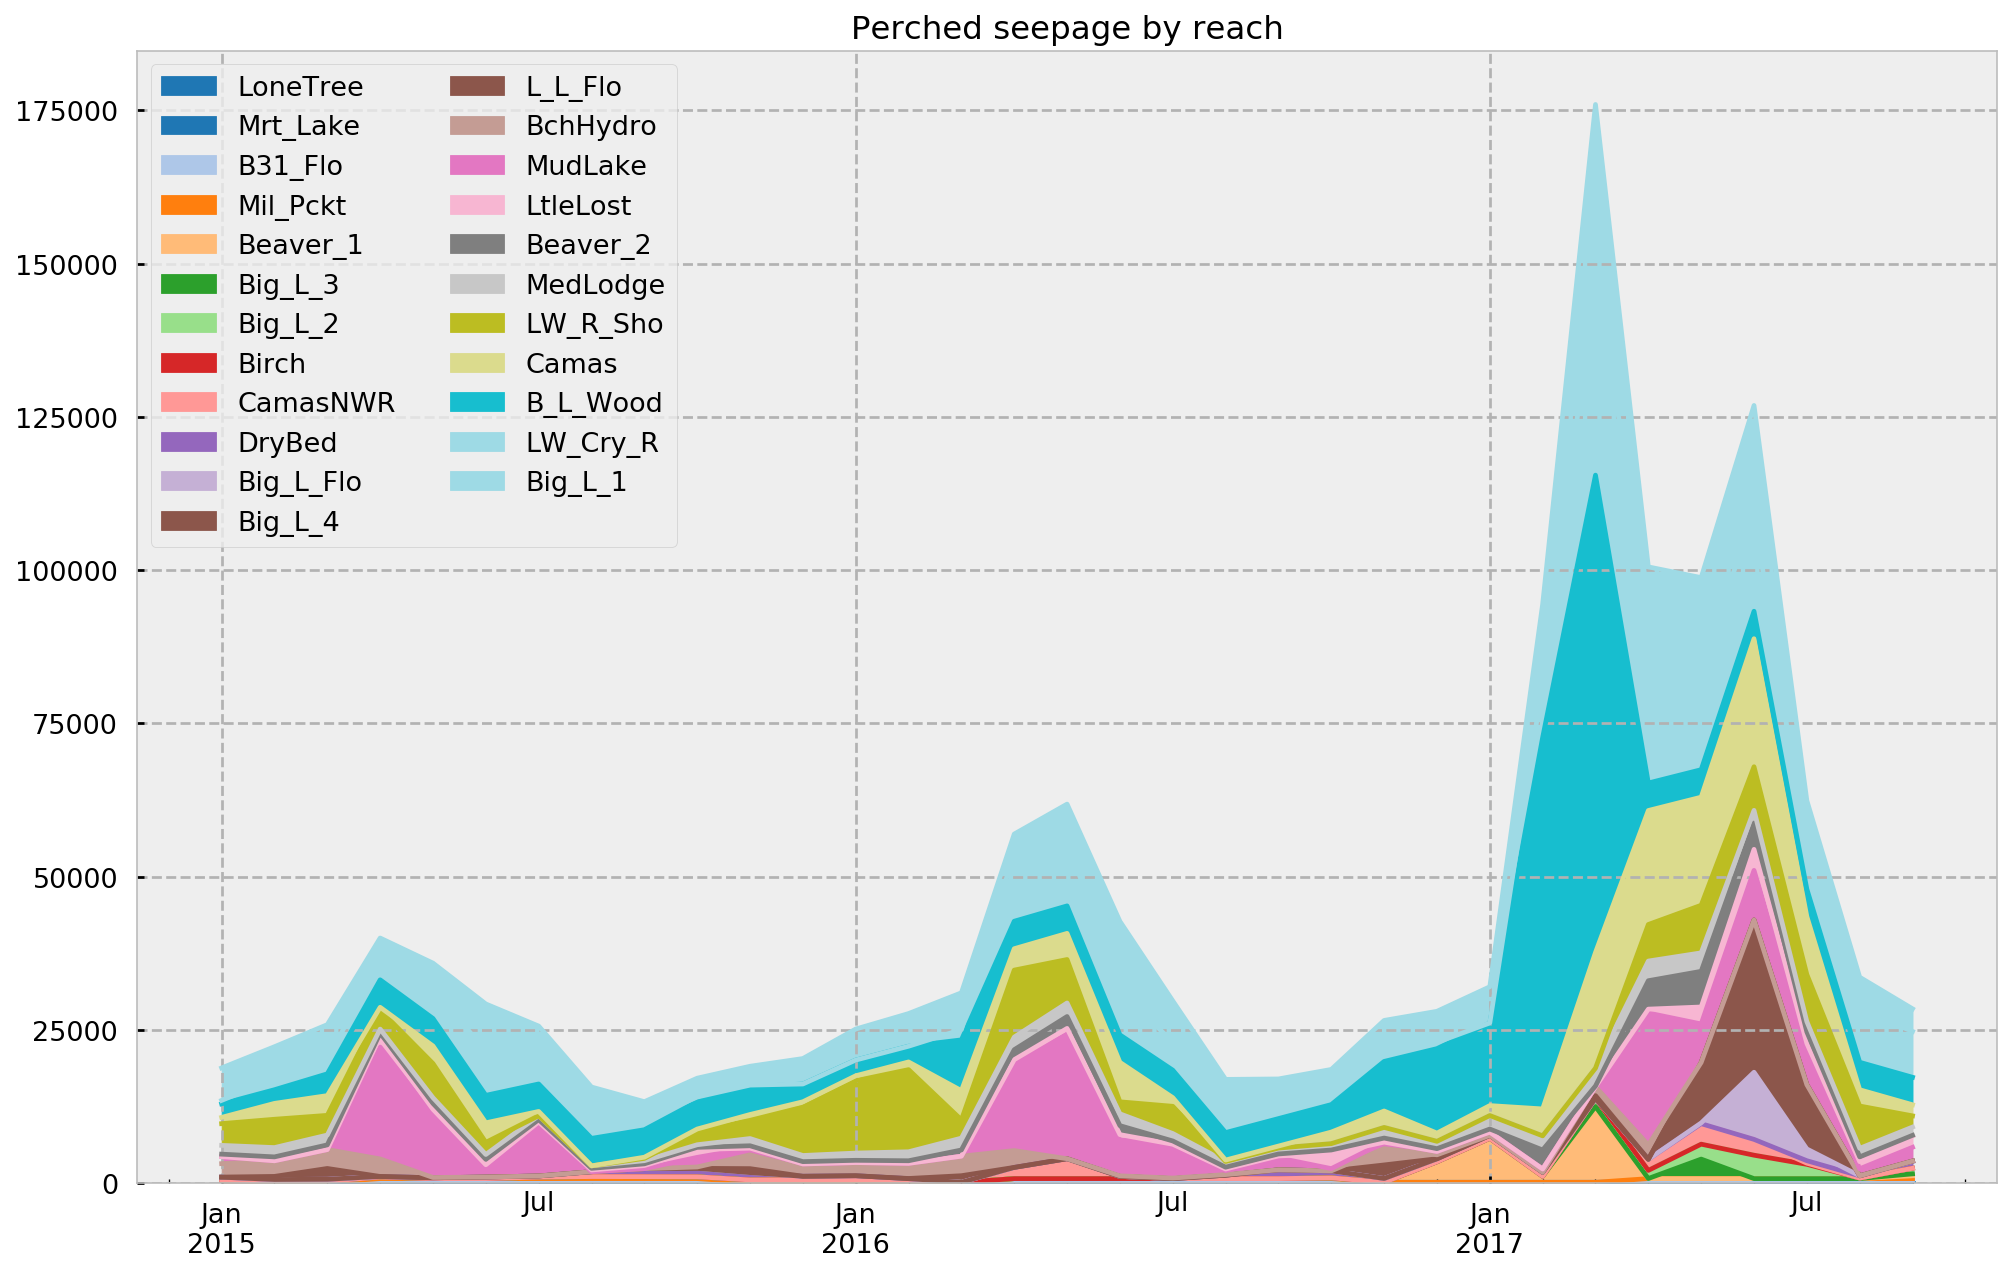

In [27]:
# Plot by reach, removing negative mudlake values
df.loc['2015-1-1':,df.mean().sort_values().index].where(df >=0,0).plot(kind='area',cmap='tab20',figsize=(16,10))
plt.legend(loc='upper left',ncol=2);
plt.title('Perched seepage by reach');

## FPT

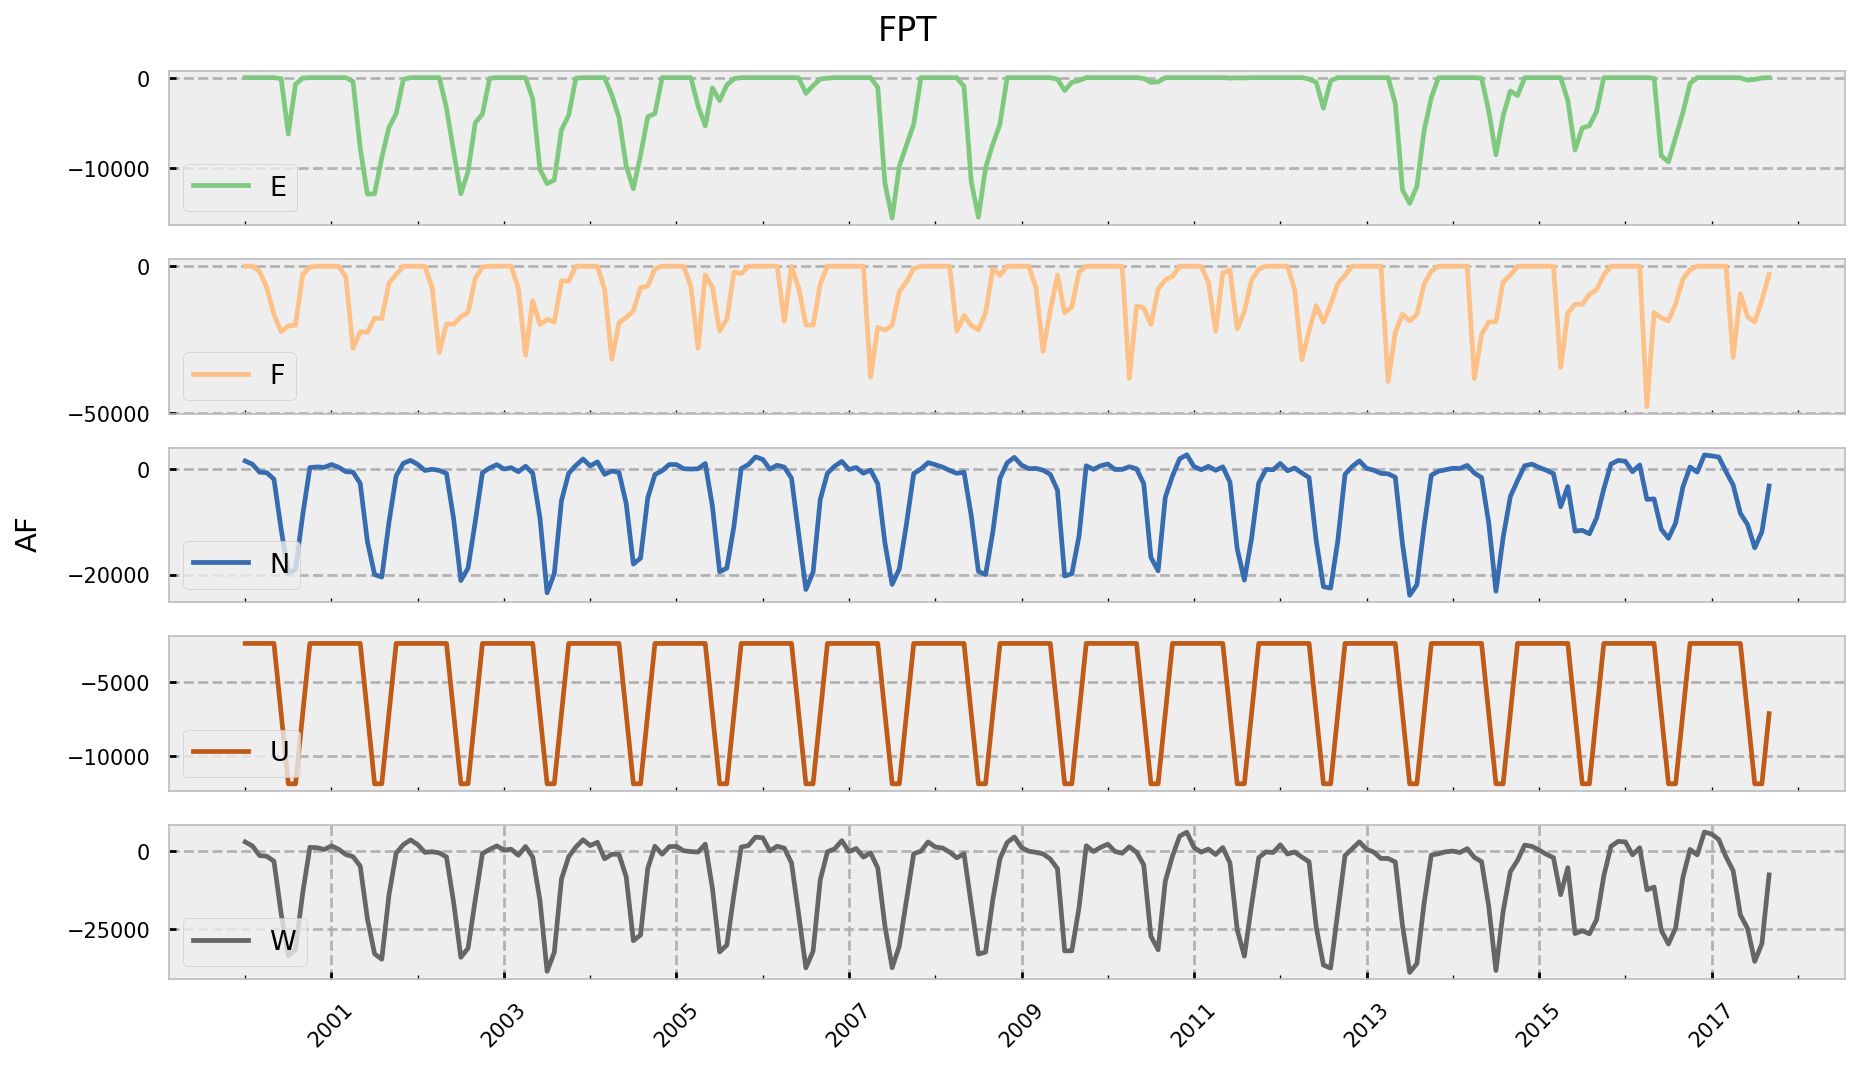

In [286]:
#-----------------------------------------------------------------
#FIG 6: ALL FPT
f=r'D:\ESRP\RechargeData_Alex\FPT\ESPAM2_FPT_197905_201709.csv'
dfMOD = pd.read_csv(f, header= 0, index_col=0)
stress_periods = ['S'+str(x) for x in  np.arange(417,450)]
#dfFPTp = dfFPTp.T
#dfFPTp.columns = stress_periods
#
#temp = dfMOD.loc[dfMOD.index.str.contains('W|N'),:'S416']
#temp = temp.merge(dfFPTp,right_index=True,left_index=True)
#dfMOD.loc[dfMOD.index.str.contains('W|N'),:] = temp
#dfMOD.apply(np.round).to_csv(r'D:\ESRP\RechargeData_Alex\FPT\ESPAM2_FPT_197905_201709.FPT')
FPTtype = dfMOD.index.str[0]
FPTts = dfMOD.apply(lambda x: (x - x.mean())/x.std(),axis=1).groupby(FPTtype).sum().T
FPTts = dfMOD.groupby(FPTtype).sum().T
FPTts.index = pd.date_range(end='2017-9-1',freq='MS',periods=len(FPTts))
FPTts = FPTts.div(1000)*1000/43560

figFPT, axFPT = plt.subplots(5,1)
FPTts['2000-1-1':].plot(ax=axFPT,cmap='Accent',subplots=True,fontsize=10)
figFPT.text(.035,0.5,'AF',
         va='center', rotation='vertical',
         fontsize=14)
axes = figFPT.get_axes()
[a.legend( loc='lower left') for a in axes ]
[plt.setp(a.xaxis.get_majorticklabels(),rotation=45) for a in axes]
[ a.set_xticks([]) for a in axes[0:4] ]
figFPT.suptitle('FPT',fontsize=16)
figFPT.tight_layout(rect=(.05,0,1,.95))

## Offsite 

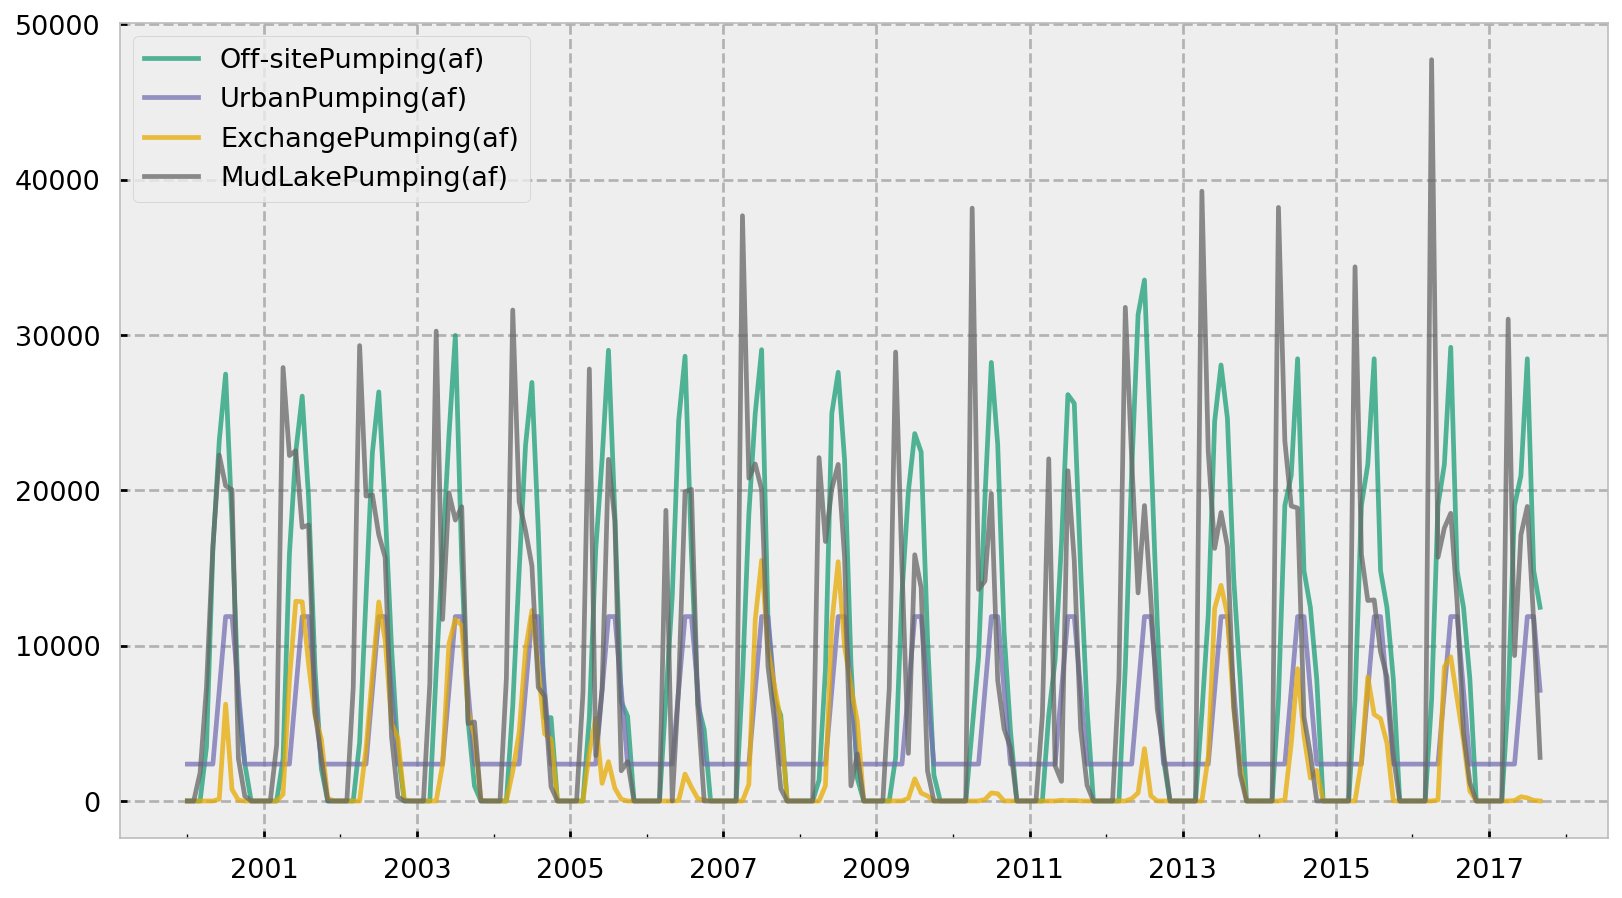

In [30]:
df = dMKMOD['Table 2']

df = df.filter(regex='Other').filter(regex='Off|Urban|Exchange|Mud')
df.columns = df.columns.droplevel(0)
df['2000-1-1':].plot(alpha=0.75,cmap='Dark2');

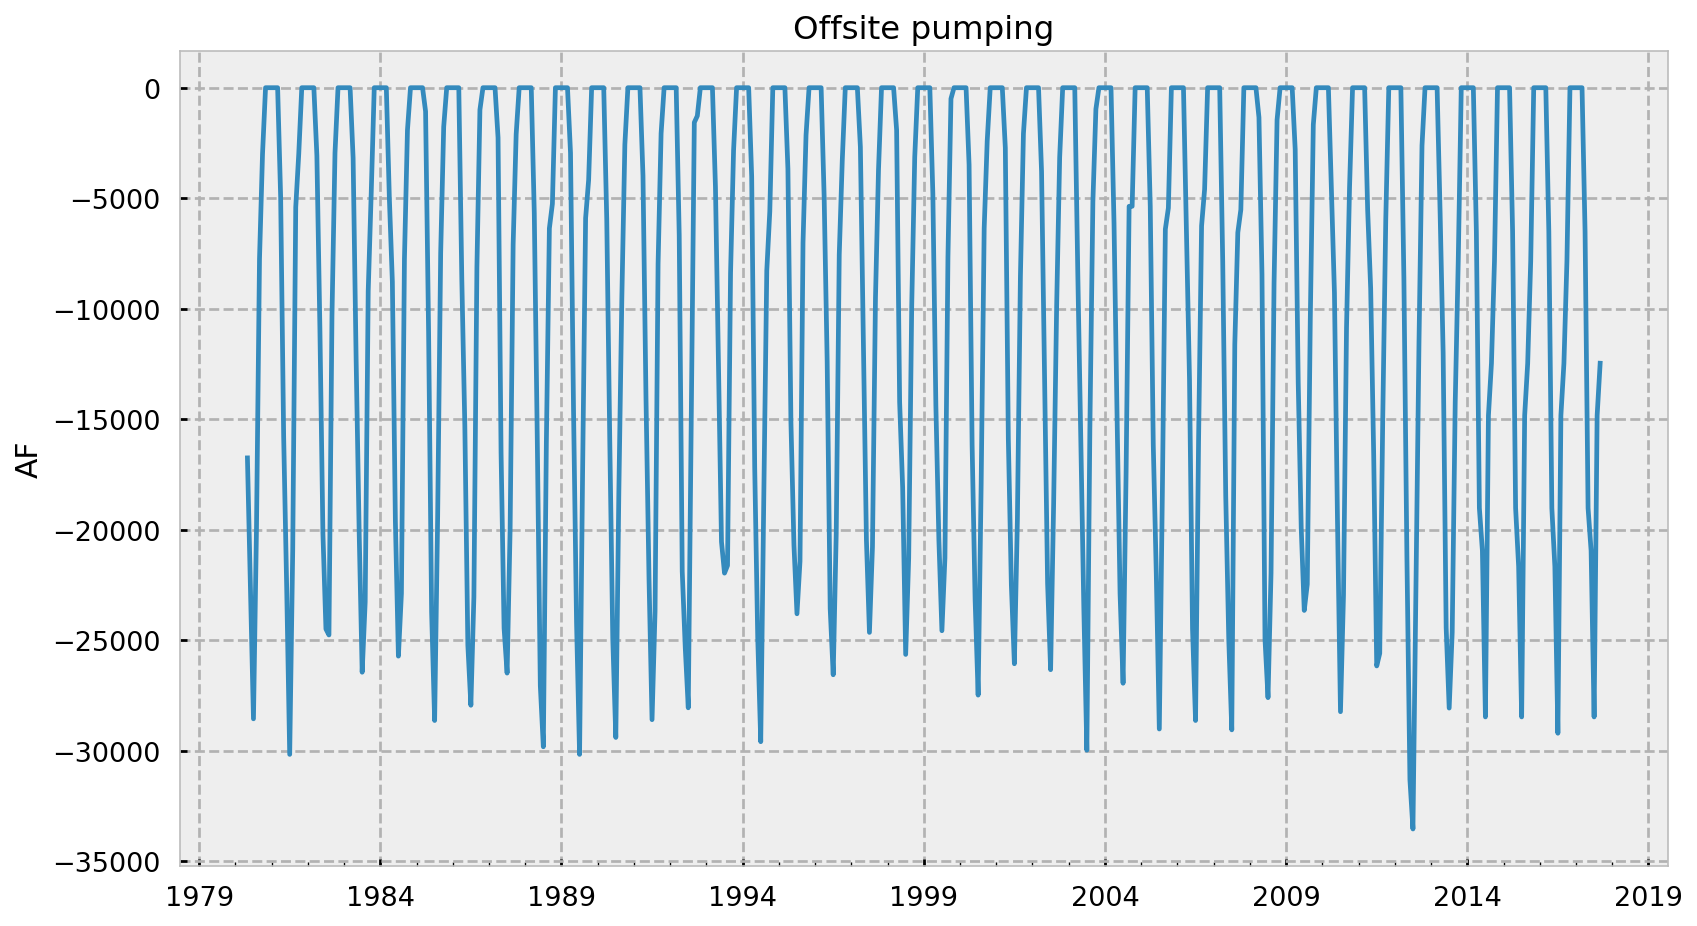

In [300]:
f = os.path.join(root,'OFF','ESPAM2x_offsite_201709.csv')
dfOFF = pd.read_csv(f, index_col=0, header=0)
dfOFF = dfOFF.div(43560)
dfOFF.columns = dfOFF.columns.map(dict(zip(['SP{0:03d}'.format(x) for x in np.arange(1,450)],stress_ts)))
axOFF = dfOFF.sum().plot(title='Offsite pumping');
axOFF.set_ylabel('AF');

## Non-irrigated Recharge
### Need to read in MKMOD output

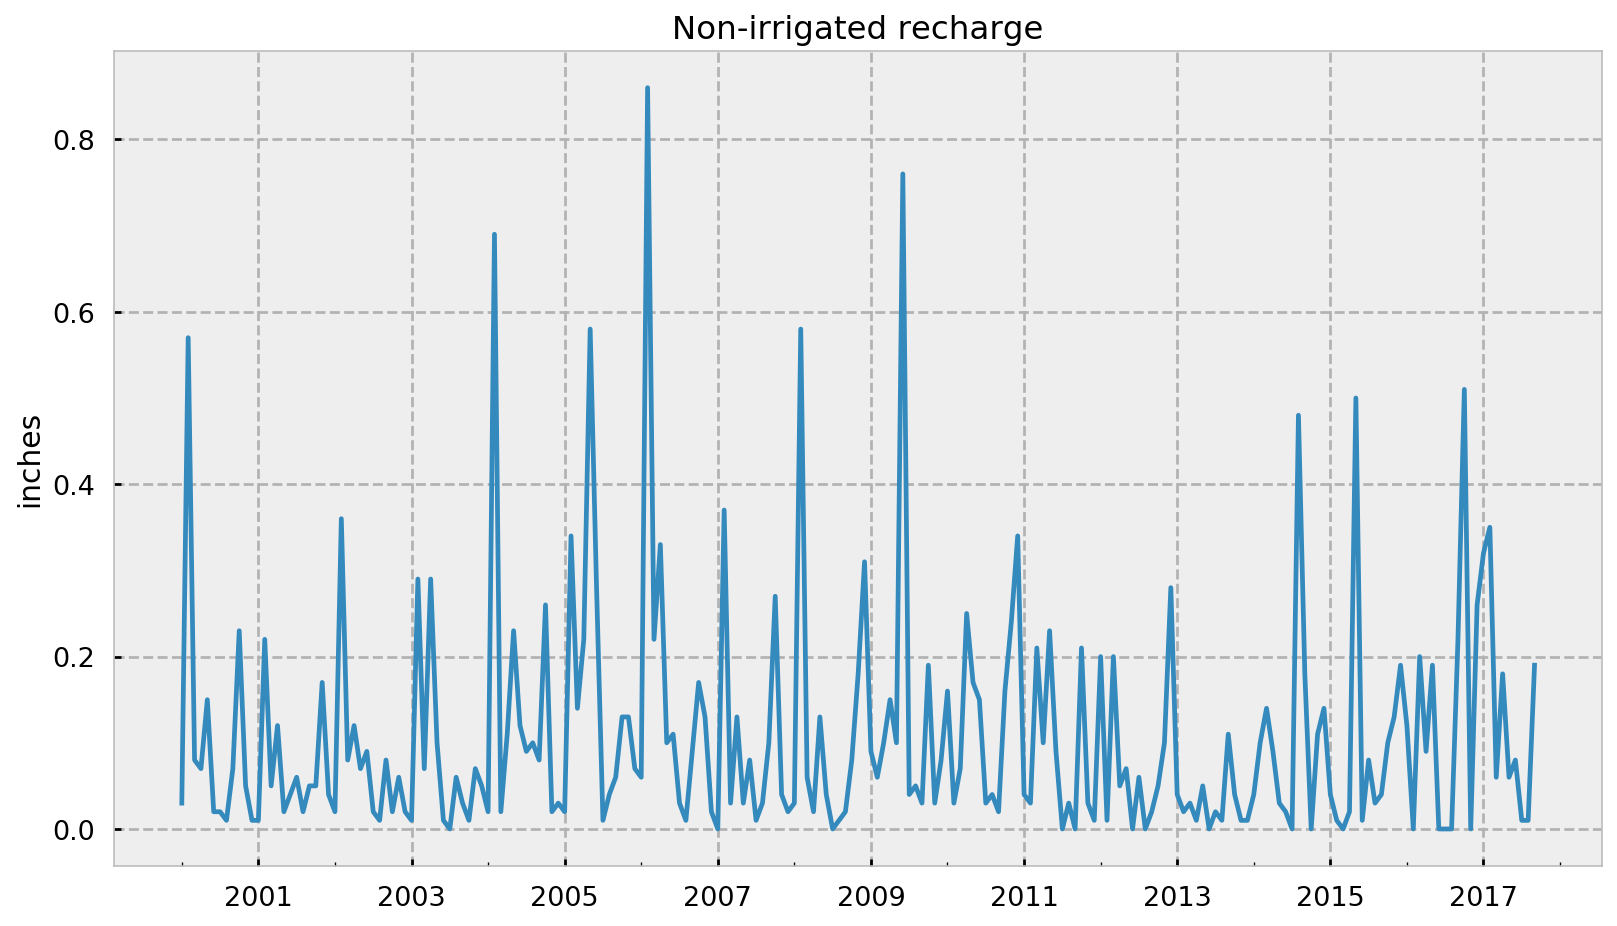

In [32]:
# 1. input from NIR csv, pre-MKMOD
# f = os.path.join(root,'NIR','NIR_201709.csv')
# df = pd.read_csv( f, index_col = 3, header= 0)
# df = df.filter(regex='S.*')
# # Pick random period after 343 to identify inactive cells (NIR == 0)
# df.columns = df.columns.map(sp2ts)

# 2. MKMOD
dMKMOD['Table 2'].loc['2000-1-1':,('Non-Irrigated Land','Rate(inches)')].plot(title='Non-irrigated recharge');
plt.ylabel('inches');

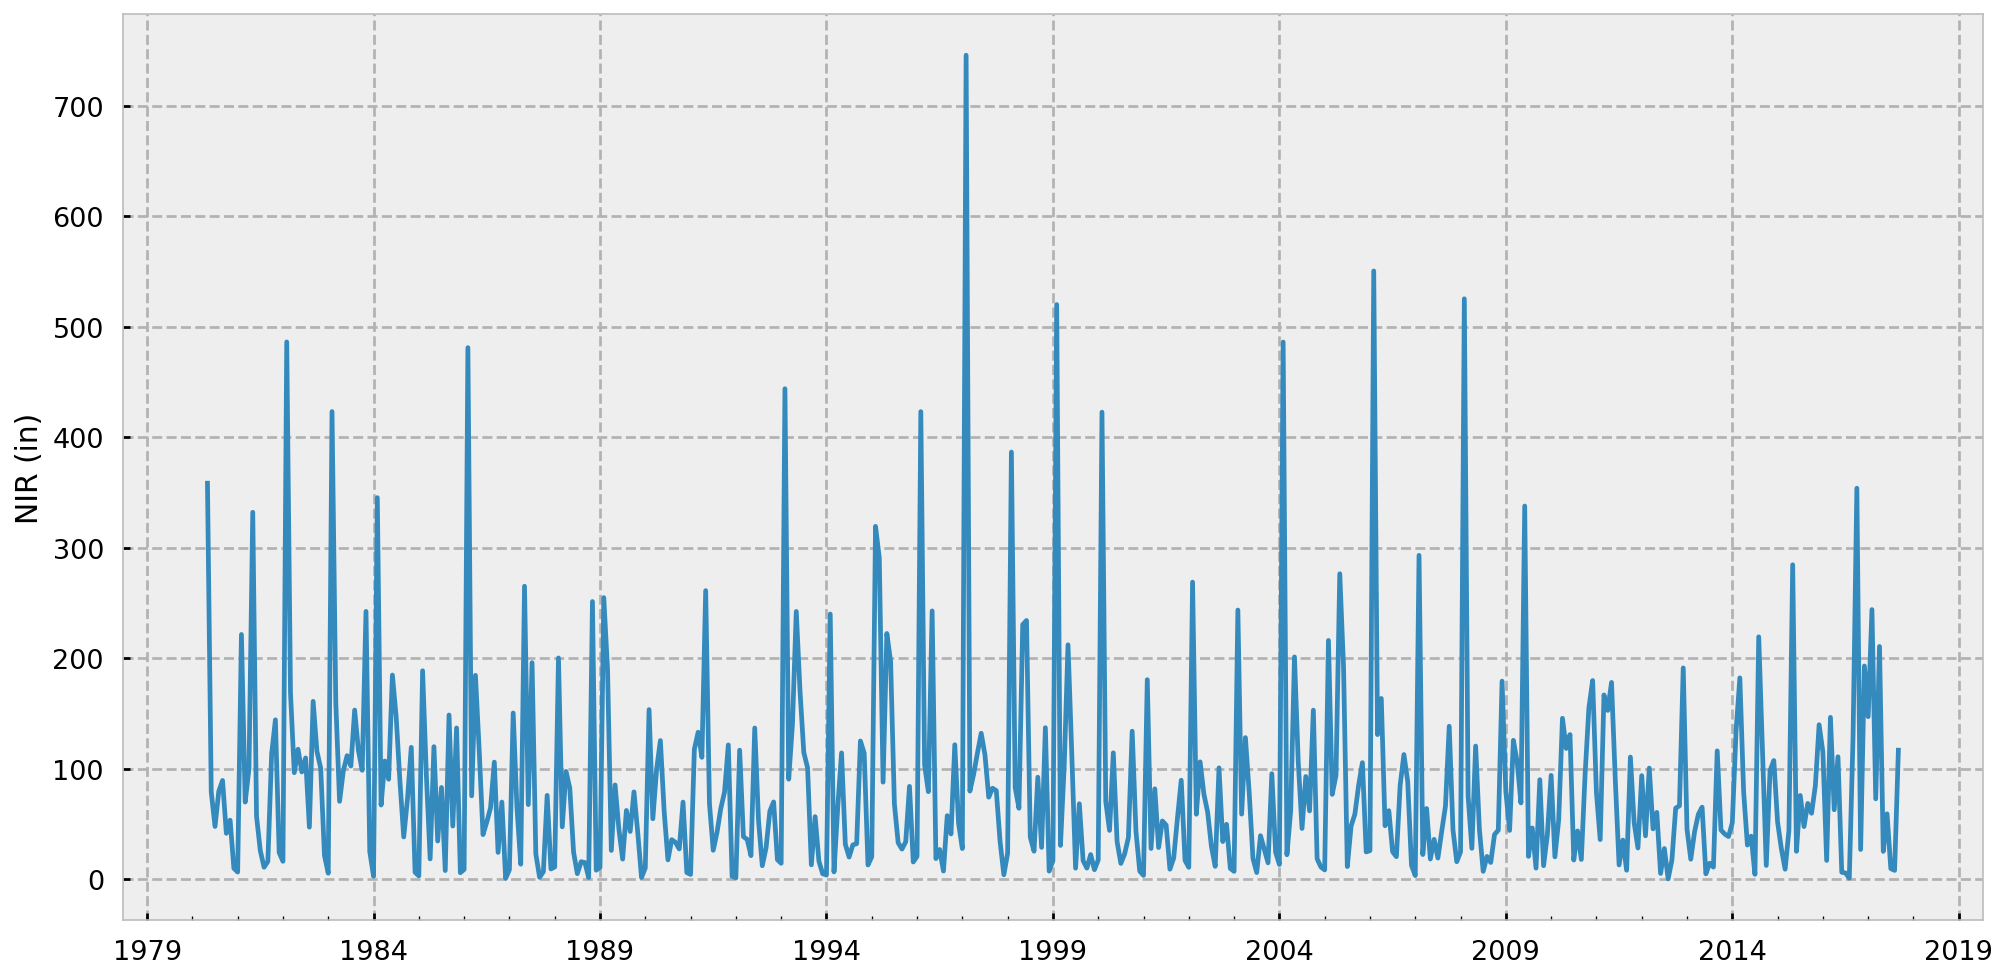

In [83]:
df.where(df.iloc[:,418] > 0 ).sum().plot(figsize=(16,8))
plt.ylabel('NIR (in)');

## Tributary Underflow

In [33]:
f = os.path.join(root,'TRB','TRBCalc','TRBCalc_throughSP449_201709.csv')
df = pd.read_csv(f, index_col=0, header=0)
df = df.filter(regex='SP.*')
df = df.div(43560) #convert to AF
df.columns = df.columns.map(dict(zip(['SP{0:03d}'.format(x) for x in  np.arange(1,450)],stress_ts)))

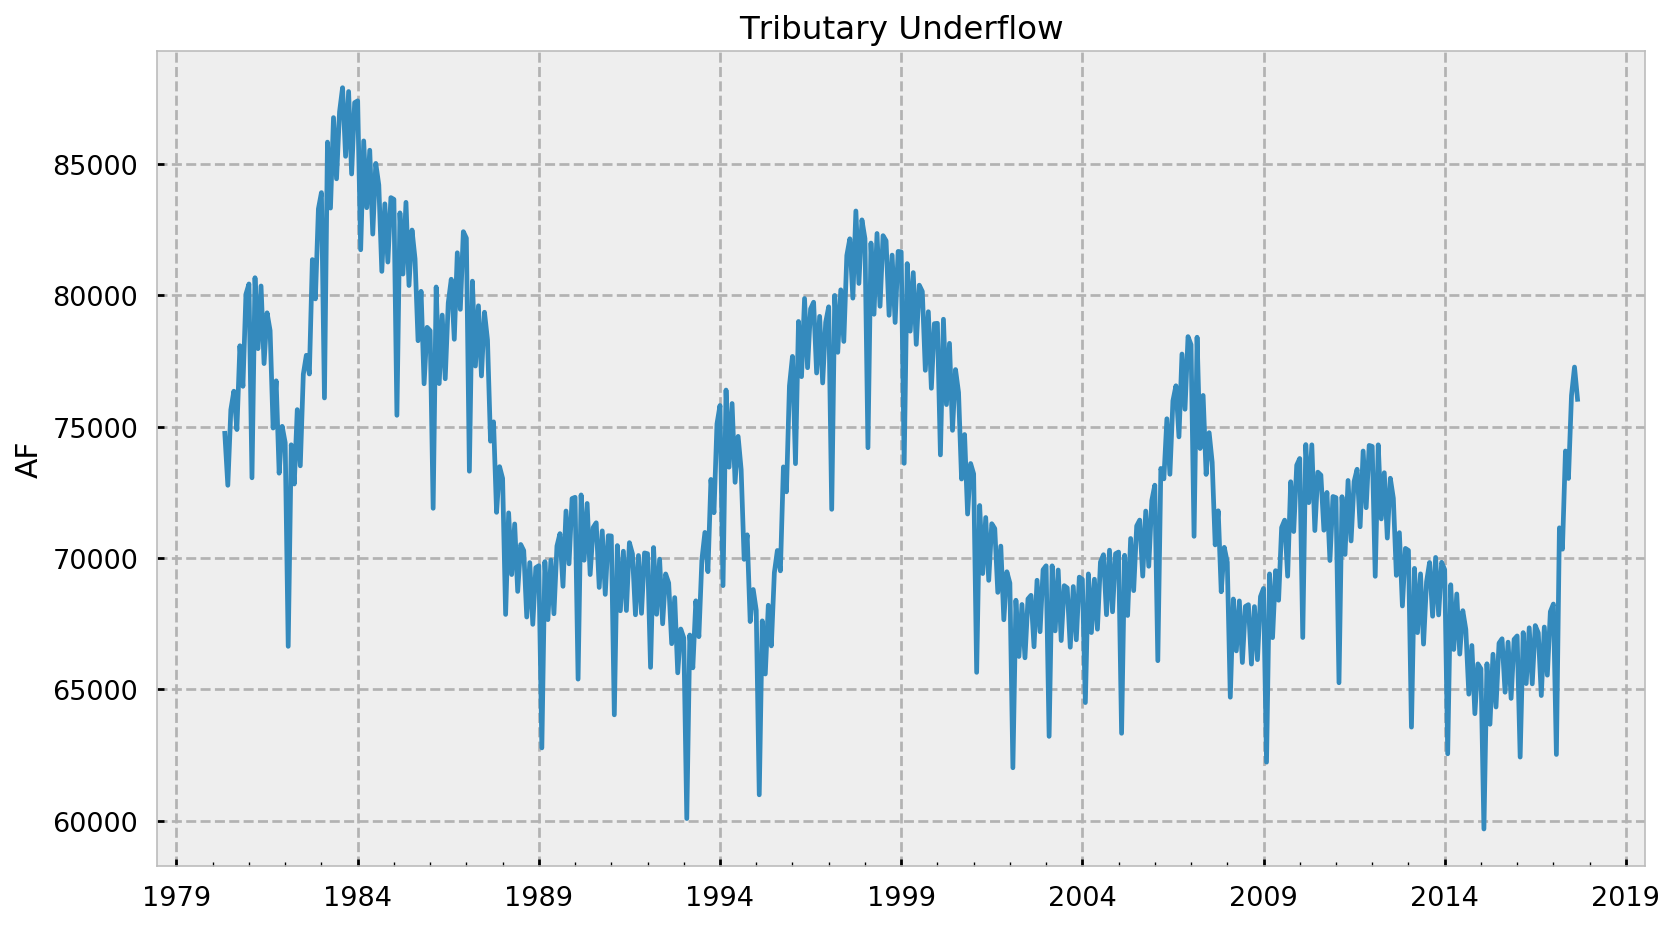

In [34]:
axTRB = df.sum().plot();
axTRB.set_ylabel('AF');
axTRB.set_title('Tributary Underflow');